# Thread topic modelling

Forum: http://forums.thefashionspot.com

In [1]:
# %load topic_functions.py
import csv
import sys
import os # added this import to process files/dirs
import re
import numpy as np
import pandas as pd
import string
from __future__ import print_function
from time import time

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline 

import nltk
#nltk.download('averaged_perceptron_tagger')
from nltk.tag import pos_tag
#stemming
from nltk import word_tokenize          
from nltk.stem import PorterStemmer 
from nltk.tokenize import RegexpTokenizer

from functools import partial

from sklearn.feature_extraction import text
from sklearn.decomposition import LatentDirichletAllocation as lda
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.datasets import fetch_20newsgroups

#hierarchica LDA
from hlda.sampler import HierarchicalLDA

from tqdm import tqdm

from ipywidgets import widgets

from IPython.core.display import HTML, display


def print_top_words(model, feature_names, n_top_words):
    topics_dataset=pd.DataFrame(columns=['Topic ID', 'Words'])
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        topic_id= topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        words=[feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]]
        print(message)
        topics_dataset= topics_dataset.append(pd.DataFrame([[topic_id, words ]],columns=['Topic ID', 'Words']))
    return  topics_dataset
    print()
    
    
class PorterTokenizer(object):
    def __init__(self):
        self.porter= PorterStemmer()
    def __call__(self, doc):
        return [self.porter.stem(t) for t in word_tokenize(doc)]

#strip any proper nouns (NNP) or plural proper nouns (NNPS) from a text
def strip_proppers(text):
    tagged = pos_tag(text.split()) #use NLTK's part of speech tagger
    nouns = [word for word,pos in tagged if pos == 'NN']
    return ' '.join(nouns)


#strip any proper nouns (NNP) or plural proper nouns (NNPS) from a text
def keep_nouns(text):
    tagged = pos_tag(text.split()) #use NLTK's part of speech tagger
    non_propernouns = [word for word,pos in tagged if pos != 'NNP' and pos != 'NNPS']
    return ' '.join(non_propernouns)


def regexp_tokenizer(text, pattern):
    tokenizer = RegexpTokenizer(pattern)
    words=tokenizer.tokenize(text)
    return ' '.join(words)



# compute lda model, tf, topics-words dataset, words-indices map
def LDA(n_samples,n_features,n_components,n_top_words,data_samples, min_df, max_df,my_stop_words):
    
    # Use tf (raw term count) features for LDA.
    print("Extracting tf features for LDA...")
    tf_vectorizer = CountVectorizer(max_df=max_df, min_df=min_df,
                                    max_features=n_features,stop_words=set(my_stop_words)
                                    , analyzer='word',tokenizer=PorterTokenizer()) # ngram_range=(1,3),tokenizer=PorterTokenizer())
    tf = tf_vectorizer.fit_transform(data_samples)

    print("Fitting LDA models with tf features, " "n_samples=%d and n_features=%d..." % (n_samples, n_features))
    lda = LatentDirichletAllocation(n_components=n_components, max_iter=5,learning_method='online',learning_offset=50.,random_state=0)

    lda.fit(tf)

    print("\nTopics in LDA model:")
    tf_feature_names = tf_vectorizer.get_feature_names()
    topics_dataset=print_top_words(lda, tf_feature_names, n_top_words)
    
    return lda,tf, topics_dataset, tf_feature_names




# compute hierarchical lda model, tf, topics-words dataset, words-indices map
def HLDA(data_samples, stopset):
    
    corpus = []
    all_docs = []
    vocab = set()

    stemmer = PorterStemmer()
    for doc in data_samples:
        doc = doc.translate(str.maketrans('', '', string.punctuation)) # strip punctuations
        doc = doc.translate(str.maketrans('', '', '0123456789')) # strip numbers        
        #doc = doc.decode("utf8").encode('ascii', 'ignore') # ignore fancy unicode chars
        all_docs.append(doc)        

        tokens = word_tokenize(str(doc))
        filtered = []
        for w in tokens:
            w = stemmer.stem(w.lower()) # use Porter's stemmer
            if len(w) < 3:              # remove short tokens
                continue
            if w in stopset:            # remove stop words
                continue
            filtered.append(w)

        vocab.update(filtered)
        corpus.append(filtered)   
    
    #Create an inverted index for the words to position in the sorted vocab
    vocab = sorted(list(vocab))
    vocab_index = {}
    for i, w in enumerate(vocab):
        vocab_index[w] = i
       
    #Convert words in the corpus into indices
    new_corpus = []
    for doc in corpus:
        new_doc = []
        for word in doc:
            word_idx = vocab_index[word]
            new_doc.append(word_idx)
        new_corpus.append(new_doc)
        
    n_samples = 100      # no of iterations for the sampler
    alpha = 10.0          # smoothing over level distributions
    gamma = 0.2 #1           # CRP smoothing parameter; number of imaginary customers at next, as yet unused table
    eta = 0.1             # smoothing over topic-word distributions
    num_levels = 3        # the number of levels in the tree
    display_topics = 10   # the number of iterations between printing a brief summary of the topics so far
    n_words = 5           # the number of most probable words to print for each topic after model estimation
    with_weights = False  # whether to print the words with the weights

    hlda = HierarchicalLDA(new_corpus, vocab, alpha=alpha, gamma=gamma, eta=eta, num_levels=num_levels)
    estimate= hlda.estimate(n_samples, display_topics=display_topics, n_words=n_words, with_weights=with_weights)
    
    colour_map = {
    0: 'blue',
    1: 'red',
    2: 'green'
    }

    def show_doc(d):

        node = hlda.document_leaves[d]
        path = []
        while node is not None:
            path.append(node)
            node = node.parent
        path.reverse()   

        n_words = 10
        with_weights = False    
        for n in range(len(path)):
            node = path[n]
            colour = colour_map[n] 
            msg = 'Level %d Topic %d: ' % (node.level, node.node_id)
            msg += node.get_top_words(n_words, with_weights)
            output = '<h%d><span style="color:%s">%s</span></h3>' % (n+1, colour, msg)
            display(HTML(output))

        display(HTML('<hr/><h5>Processed Document</h5>'))

        doc = corpus[d]
        output = ''
        for n in range(len(doc)):
            w = doc[n]
            l = hlda.levels[d][n]
            colour = colour_map[l]
            output += '<span style="color:%s">%s</span> ' % (colour, w)
        display(HTML(output))
        
    #widgets.interact(show_doc, d=0)

    return estimate

#add doc-topic distribution to the dataset
def add_doc_topic_distrib(lda, tf, dataset, new_col_name):
    res=lda.transform(tf)
    dataset[new_col_name]=res.tolist()
    return dataset

def topics_time_distrib(dataset, distrib_col, topic_dataset):
    # distrubtion of topics over the docs
    topics_time=pd.DataFrame(columns=['time'] +  ['topic%d'%i for i in range(topic_dataset.shape[0])])
    dataset['year_months']=pd.to_datetime(dataset['time'], errors='coerce').dt.to_period('M')

    #for each months compute the mean distribution of topics over the docs (here posts)
    for name, group in dataset.groupby('year_months'):
        distrib = np.asarray(list(group[distrib_col])).mean(axis=0)
        df= pd.DataFrame([[name] + list(distrib)], columns=['time'] + ['topic%d'%i for i in range(topic_dataset.shape[0])] )
        topics_time=topics_time.append(df, ignore_index=True)
    
    topics_time=topics_time.sort_values(by='time')
    time=topics_time['time']
    topics_time=topics_time.set_index('time')
    topics_time=topics_time.reset_index()
    return topics_time

def topics_forum_distrib(dataset, distrib_col, topic_dataset):
    # distrubtion of topics over the docs
    topics_forum=pd.DataFrame(columns= ['topic%d'%i for i in range(topic_dataset.shape[0])])
    
    distrib = np.asarray(list(dataset[distrib_col])).mean(axis=0)
    df= pd.DataFrame([list(distrib)], columns= ['topic%d'%i for i in range(topic_dataset.shape[0])])
    topics_forum=topics_forum.append(df, ignore_index=True)
    
    topics_forum.plot(kind='bar')
    return topics_forum

#for each topic print the number of times the word appears in all posts
def topics_words_distrib(topics_dataset, tf_feature_names, tf):
    #for each topic
    topics_words_count=pd.Series()
    for name, group in topics_dataset.groupby('Topic ID'):
        #for each word
        counts=[]
        for word in group['Words'][0]:
            #find the number of time it appears in the all forum
            #find ind of word in features name
            ind = tf_feature_names.index(word)
            #compute sum of tf column to have #times the word appear in the hole dataset
            counts.append(tf[:,ind].sum())
        topics_words_count= topics_words_count.append(pd.Series([counts]))
    topics_dataset['Words count in dataset']=topics_words_count
    return topics_dataset

#words count per month per topic 
def words_count_time(topics_dataset, tf, tf_feature_names,dataset):
    #for each topic 
    dataset['year_months']=pd.to_datetime(dataset['time'], errors='coerce').dt.to_period('M')
    words_count_time=pd.DataFrame()
    time=dataset['year_months'].unique()
    #print(time)
    for name, group in topics_dataset.groupby('Topic ID'):
        # for each word
        for word in group['Words'][0]:
            #find ind of word 
            ind_word = tf_feature_names.index(word)
            word_counts=[]
            time2=[]
            for name , group in dataset.groupby('year_months'):
                #print(name)
                time2=time2 + [name]
                #get ind of docs in that period
                ind_doc = list(group.index)
                #get counts of this word in that period
                word_counts= word_counts  + list(np.ndarray.flatten(np.asarray(tf[ind_doc,ind_word].sum(axis=0))));
                
            words_count_time[word]= pd.Series(word_counts)
    time=pd.Series(time.tolist())
    time=time.dropna()
    words_count_time['time']=time
    words_count_time=words_count_time.sort_values('time')
    words_count_time= words_count_time[~words_count_time.time.isnull()]
    #words_count_time = words_count_time.set_index('time').drop(pd.NaT)


    #words_count_time= words_count_time.set_index(time)
    
    return words_count_time

#keep propers nouns
def keep_propers(text):
    tagged = pos_tag(text.split()) #use NLTK's part of speech tagger
    propernouns = [word for word,pos in tagged if pos == 'NNP' or pos == 'NNPS']
    return ' '.join(propernouns)

#words count per month per topic 
def proper_nouns_count_time(proper_nouns_count, tf, tf_feature_names,dataset):
    #for each topic 
    dataset['year_months']=pd.to_datetime(dataset['time'], errors='coerce').dt.to_period('M')
    words_count_time=pd.DataFrame()
    time=dataset['year_months'].unique()
    
    # for each word
    for word in proper_nouns_count['proper nouns']:
        #find ind of word 
        ind_word = tf_feature_names.index(word)
        word_counts=[]
        for name , group in dataset.groupby('year_months'):
            #get ind of docs in that period
            ind_doc = list(group.index)
            #get counts of this word in that period
            word_counts= word_counts  + list(np.ndarray.flatten(np.asarray(tf[ind_doc,ind_word].sum(axis=0))));
                
        words_count_time[word]= pd.Series(word_counts)
    time=pd.Series(time.tolist())
    time=time.dropna()
    words_count_time['time']=time
    words_count_time=words_count_time.sort_values('time')
    words_count_time= words_count_time[~words_count_time.time.isnull()]
    return words_count_time

## A thread topics modelling  : Post granularity
Here each posts' text is consider as one document for the Latent Dirichlet algorithm

### Import all posts from the dataset
Import the dataset, here it is the posts scrapped from the folder 'Designers and Collections' (i.e folder 0).
I kept only the text of the posts to apply the LDA algorithm.
Since all posts

In [2]:
print("Loading dataset...")
path='../data/posts_2.csv'
all_posts= pd.read_csv(path,parse_dates=['time'])
print('Dataset size: {}'.format(all_posts.shape))
all_posts.head()

Loading dataset...
Dataset size: (1718779, 8)


,ID,Thread ID,author,number,post,quote,tag,time
0,10105655,162311.0,Chanelcouture09,1.0,Moderator's Note: Falsely or non credited pi...,[],[],04-01-2012
1,10107983,162311.0,PonyShow,2.0,Credit: suninscorpio.tumblr.com,[],[],04-01-2012
2,10108063,162311.0,Chanelcouture09,3.0,^John Galliano Fall Winter 2009.,[],[],04-01-2012
3,10114851,162311.0,Menace,4.0,If the insect blouse and rainbow dress are ...,[],[],06-01-2012
4,10114885,162311.0,get fashion,5.0,The dress it's Christopher Kane Reso...,[],[],06-01-2012


### Select a thread from which we want to detect the topic

In [3]:
thread_id= 162311
posts=all_posts[all_posts['Thread ID']==thread_id]
dataset=all_posts[all_posts['Thread ID']==thread_id]['post']
print('Dataset size: {}'.format(dataset.size))
dataset.head()

Dataset size: 614


0     Moderator's Note:  Falsely or non credited pi...
1                  Credit: suninscorpio.tumblr.com    
2                 ^John Galliano Fall Winter 2009.    
3       If the insect blouse and rainbow dress are ...
4              The dress it's Christopher Kane Reso...
Name: post, dtype: object

### LDA 
Paramters to change:
* **n_features**: number of words in the dictionnary
* **n_components**: number of topics to detect
* **n_top_words**: the n most important words in each topics (to share to have insight about the topic)

In [63]:
n_features = 3000
n_components =  5 
n_top_words = 10

In [64]:
#adding months as stop words
months=['january', 'february', 'march','april', 'may','june', 'july','august', 'september','october','november','december']
stop_words_plus=['com', 'http','www','t','s','fr','vs', 'https', 'html','w','l', 'thank', 'source', 'post','thread','know','lot', 'forum', 'got', 'facebook', 'credit', 'id',  'bit', 'ly', 'anybody', 'jpg', 'u', 'net', 'kz', 'uk']
authors=posts['author']
pronouns=['versace','vogue','christian','nowfashion', 'balenciaga', 'mak', 'stylebistro','voguerunway', 'dior', 'instagram','dolce', 'dolce gabbana', 'gabbana','ccp','yves','saint', 'fenrost', 'mistress_f', 'carol', 'carol poell','poell','simon', 'nowfashion.com', 'thefashionspot', 'van', 'givenchy', 'buro247']
my_stop_words = text.ENGLISH_STOP_WORDS.union(months, stop_words_plus,pronouns,string.punctuation,authors)
my_stop_words=my_stop_words.union([PorterStemmer().stem(t) for t in my_stop_words])



#### Without propers nouns

The proper nouns are stripped from the posts text. As we expect them to correspond to brands or designers in most part, I will used them later to try to detect trends. Numbers and months which are added to stop-words are also stripped from the text. I'm still not sure how to incomporate the months, as they could represent seasons which regulate the collections (i.e F/W collection of Zara), hence they will maybe used later.

In [65]:
#remove proper names
non_proper_nouns = [strip_proppers(thread) for thread in dataset]
#dataset = list(filter(lambda word: word not in my_stop_words, word_list))
non_proper_nouns=[regexp_tokenizer(thread, u'(?ui)\\b\\w*[a-z]+\\w*\\b') for thread in non_proper_nouns]

In [66]:
#take the entire dataset
n_samples = len(dataset) 
data_samples = non_proper_nouns

lda, tf, topics_words, tf_feature_names=LDA(n_samples,n_features,n_components,n_top_words,data_samples,2, 0.95, my_stop_words)
topics_words

Extracting tf features for LDA...
Fitting LDA models with tf features, n_samples=614 and n_features=3000...

Topics in LDA model:
Topic #0: tumblr advanc shirt outfit pictur help hoodi cccxii hrsvt fashionscansremast
Topic #1: brand p blazer right imag zh editori print model cover
Topic #2: dress collect help coat design fall season year magazin model
Topic #3: style jacket sweater collect fashionshow piec inform ve tf site
Topic #4: skirt design spring season collect look photo catwalk campaign summer


,Topic ID,Words
0,0,"[tumblr, advanc, shirt, outfit, pictur, help, ..."
0,1,"[brand, p, blazer, right, imag, zh, editori, p..."
0,2,"[dress, collect, help, coat, design, fall, sea..."
0,3,"[style, jacket, sweater, collect, fashionshow,..."
0,4,"[skirt, design, spring, season, collect, look,..."


#### With only Nouns

In [67]:
#keep nouns
nouns = [keep_nouns(thread) for thread in dataset]
#dataset = list(filter(lambda word: word not in my_stop_words, word_list))
nouns=[regexp_tokenizer(thread, u'(?ui)\\b\\w*[a-z]+\\w*\\b') for thread in nouns]

In [68]:
#take the entire dataset
n_samples = len(dataset) 
data_samples = nouns

lda, tf, topics_words, tf_feature_names=LDA(n_samples,n_features,n_components,n_top_words,data_samples,2, 0.95, my_stop_words)
topics_words

Extracting tf features for LDA...
Fitting LDA models with tf features, n_samples=614 and n_features=3000...

Topics in LDA model:
Topic #0: style shoe guy fashionshow right imag cara br recogn uol
Topic #1: doe imag campaign site zh come ad welcom tf inform
Topic #2: dress design help wear tumblr collect spring jacket coat skirt
Topic #3: look collect help runway season pictur identifi fall like design
Topic #4: shirt look photo want collect sure model brand just skirt


,Topic ID,Words
0,0,"[style, shoe, guy, fashionshow, right, imag, c..."
0,1,"[doe, imag, campaign, site, zh, come, ad, welc..."
0,2,"[dress, design, help, wear, tumblr, collect, s..."
0,3,"[look, collect, help, runway, season, pictur, ..."
0,4,"[shirt, look, photo, want, collect, sure, mode..."


### Hierarchical LDA

In [51]:
estimate= HLDA(data_samples,  my_stop_words)

HierarchicalLDA sampling
.......... 10
topic 0 (level=0, total_words=654, documents=614): dress, collect, style, tumblr, design, 
    topic 1 (level=1, total_words=19, documents=28): print, leem, live, cours, mode, 
        topic 31 (level=2, total_words=2, documents=2): celebr, question, zuhair, gwgaabig, hat, 
        topic 50 (level=2, total_words=1, documents=3): advanc, zuhair, guy, hat, harpersbazaar, 
        topic 122 (level=2, total_words=3, documents=3): iao, outfit, roberto, zuhair, grey, 
        topic 254 (level=2, total_words=0, documents=1): zuhair, guy, hat, harpersbazaar, harinef, 
        topic 257 (level=2, total_words=2, documents=2): variat, rogu, gobritney, guy, harpersbazaar, 
        topic 281 (level=2, total_words=6, documents=4): idmb, silhouett, suit, gwgaabig, inform, 
        topic 319 (level=2, total_words=3, documents=4): summer, oncethingslookup, stardustevangelist, guy, harpersbazaar, 
        topic 359 (level=2, total_words=4, documents=4): newslici, j

.......... 20
topic 0 (level=0, total_words=652, documents=614): dress, collect, style, tumblr, design, 
    topic 1 (level=1, total_words=11, documents=31): magazin, model, cloth, leg, summer, 
        topic 375 (level=2, total_words=5, documents=3): idea, visual, fashion, black, red, 
        topic 467 (level=2, total_words=1, documents=4): voguepedia, zuhair, guy, hat, harpersbazaar, 
        topic 485 (level=2, total_words=1, documents=3): thx, guy, hat, harpersbazaar, harinef, 
        topic 508 (level=2, total_words=2, documents=3): similar, ladi, zuhair, grey, harpersbazaar, 
        topic 674 (level=2, total_words=5, documents=3): gener, warmer, mixedpass, exampl, inform, 
        topic 690 (level=2, total_words=2, documents=3): grey, julianwatsonag, guy, hat, harpersbazaar, 
        topic 720 (level=2, total_words=0, documents=2): zuhair, guy, hat, harpersbazaar, harinef, 
        topic 759 (level=2, total_words=0, documents=2): zuhair, guy, hat, harpersbazaar, harinef, 
     

.......... 30
topic 0 (level=0, total_words=626, documents=614): dress, collect, style, design, tumblr, 
    topic 1 (level=1, total_words=10, documents=18): entertain, voguishq, dailymail, fashioncirql, hbo, 
        topic 804 (level=2, total_words=6, documents=7): lace, tumblr, hrsvt, seri, season, 
        topic 1141 (level=2, total_words=1, documents=5): msn, zuhair, guy, harpersbazaar, harinef, 
        topic 1144 (level=2, total_words=0, documents=2): zuhair, guy, hat, harpersbazaar, harinef, 
        topic 1159 (level=2, total_words=2, documents=4): orig, edit, heatherhuey, hat, harpersbazaar, 
    topic 3 (level=1, total_words=32, documents=35): magazin, grate, ident, pollut, blazer, 
        topic 1026 (level=2, total_words=3, documents=3): summer, underneath, bustier, godddd, hat, 
        topic 1061 (level=2, total_words=11, documents=4): figur, need, work, mood, pscccf, 
        topic 1100 (level=2, total_words=5, documents=4): thing, manoloshoeblog, zigzag, highsnobieti, r

.......... 40
topic 0 (level=0, total_words=638, documents=614): dress, collect, style, design, tumblr, 
    topic 1 (level=1, total_words=13, documents=27): sonia, undercov, print, stylist, land, 
        topic 1464 (level=2, total_words=1, documents=2): vladafan, zuhair, hat, harpersbazaar, harinef, 
        topic 1597 (level=2, total_words=1, documents=3): vladafan, zuhair, hat, harpersbazaar, harinef, 
        topic 1669 (level=2, total_words=6, documents=4): crazi, fashionablephotographi, buro, wordpress, pleaseee, 
        topic 1686 (level=2, total_words=7, documents=5): shot, postimg, care, org, outfit, 
        topic 1829 (level=2, total_words=0, documents=2): zuhair, guy, hat, harpersbazaar, harinef, 
        topic 1840 (level=2, total_words=1, documents=4): right, zuhair, grey, harpersbazaar, harinef, 
        topic 1878 (level=2, total_words=9, documents=7): sneaker, male, think, judg, muscl, 
    topic 3 (level=1, total_words=18, documents=23): rest, bag, idea, life, theyr

.......... 50
topic 0 (level=0, total_words=627, documents=614): dress, collect, style, design, tumblr, 
    topic 1 (level=1, total_words=4, documents=4): letter, rhineston, shirt, sandal, guy, 
        topic 2513 (level=2, total_words=10, documents=4): write, block, unsur, backstag, scarf, 
    topic 3 (level=1, total_words=20, documents=18): iphoto, print, style, runway, stylestreetfashion, 
        topic 1722 (level=2, total_words=2, documents=3): backstag, fashionologi, zuhair, heatherhuey, hat, 
        topic 1930 (level=2, total_words=16, documents=4): chevron, insert, vll, lace, fashionshow, 
        topic 2059 (level=2, total_words=0, documents=1): zuhair, guy, hat, harpersbazaar, harinef, 
        topic 2237 (level=2, total_words=4, documents=2): water, subir, foto, seri, grey, 
        topic 2267 (level=2, total_words=0, documents=2): zuhair, guy, hat, harpersbazaar, harinef, 
        topic 2294 (level=2, total_words=1, documents=2): stariti, zuhair, guy, harpersbazaar, hari

.......... 60
topic 0 (level=0, total_words=632, documents=614): dress, collect, style, tumblr, design, 
    topic 3 (level=1, total_words=28, documents=32): chevron, pattern, bwgreyscal, fall, def, 
        topic 1930 (level=2, total_words=13, documents=8): insert, version, vll, lace, livejourn, 
        topic 2611 (level=2, total_words=6, documents=3): blood, planet, shirt, zigzag, singapor, 
        topic 2931 (level=2, total_words=0, documents=5): zuhair, guy, hat, harpersbazaar, harinef, 
        topic 2983 (level=2, total_words=0, documents=1): zuhair, guy, hat, harpersbazaar, harinef, 
        topic 3021 (level=2, total_words=5, documents=2): pro, shop, quilt, philliplim, holiday, 
        topic 3058 (level=2, total_words=0, documents=1): zuhair, guy, hat, harpersbazaar, harinef, 
        topic 3061 (level=2, total_words=3, documents=4): seoul, tfser, left, hat, harinef, 
        topic 3077 (level=2, total_words=1, documents=3): voguishq, zuhair, guy, hat, harpersbazaar, 
      

.......... 70
topic 0 (level=0, total_words=624, documents=614): dress, collect, style, tumblr, design, 
    topic 3 (level=1, total_words=4, documents=10): laiamagazin, omg, magazin, fabric, grey, 
        topic 1930 (level=2, total_words=3, documents=5): actual, bryanboy, twitter, zuhair, haider, 
        topic 3368 (level=2, total_words=1, documents=1): blog, guy, hat, harpersbazaar, harinef, 
        topic 3558 (level=2, total_words=2, documents=1): modelcoutur, livejourn, zuhair, hat, harpersbazaar, 
        topic 3765 (level=2, total_words=1, documents=3): nymag, zuhair, guy, hat, harpersbazaar, 
    topic 6 (level=1, total_words=4, documents=6): kind, tumblr, red, variat, zuhair, 
        topic 3299 (level=2, total_words=4, documents=3): tfser, sweater, browndresswithwhitedot, seoul, zuhair, 
        topic 3310 (level=2, total_words=0, documents=1): zuhair, guy, hat, harpersbazaar, harinef, 
        topic 3583 (level=2, total_words=0, documents=2): zuhair, guy, hat, harpersbazaa

.......... 80
topic 0 (level=0, total_words=672, documents=614): dress, collect, style, tumblr, design, 
    topic 3 (level=1, total_words=9, documents=10): fashion, zip, tess, play, want, 
        topic 3941 (level=2, total_words=1, documents=1): right, zuhair, grey, harpersbazaar, harinef, 
        topic 3967 (level=2, total_words=0, documents=2): zuhair, guy, hat, harpersbazaar, harinef, 
        topic 4285 (level=2, total_words=4, documents=5): kind, sleev, bow, ident, hrsvt, 
        topic 4373 (level=2, total_words=0, documents=1): zuhair, guy, hat, harpersbazaar, harinef, 
        topic 4437 (level=2, total_words=0, documents=1): zuhair, guy, hat, harpersbazaar, harinef, 
    topic 6 (level=1, total_words=2, documents=8): stariti, quilt, zuhair, guy, harinef, 
        topic 4226 (level=2, total_words=1, documents=2): bwgreyscal, gwgaabig, hbo, hat, harpersbazaar, 
        topic 4384 (level=2, total_words=4, documents=2): seri, lavandula, lol, hbo, harpersbazaar, 
        topic 4

.......... 90
topic 0 (level=0, total_words=627, documents=614): dress, collect, style, tumblr, design, 
    topic 3 (level=1, total_words=12, documents=15): huqfridcb, minimalist, resort, blazer, riri, 
        topic 4751 (level=2, total_words=6, documents=5): event, cardigan, elitemodel, photo, slideshow, 
        topic 4765 (level=2, total_words=2, documents=1): place, gold, gwgaabig, hbo, hat, 
        topic 4831 (level=2, total_words=2, documents=2): wearesodroe, sweater, zuhair, grey, harinef, 
        topic 4899 (level=2, total_words=3, documents=2): celebrityc, coutur, realanaismali, zuhair, gwgaabig, 
        topic 4976 (level=2, total_words=0, documents=2): zuhair, guy, hat, harpersbazaar, harinef, 
        topic 5023 (level=2, total_words=0, documents=2): zuhair, guy, hat, harpersbazaar, harinef, 
        topic 5080 (level=2, total_words=0, documents=1): zuhair, guy, hat, harpersbazaar, harinef, 
    topic 42 (level=1, total_words=16, documents=29): descript, insect, glossyn

.......... 100
topic 0 (level=0, total_words=688, documents=614): dress, collect, style, tumblr, design, 
    topic 3 (level=1, total_words=20, documents=20): time, short, leg, troubl, cat, 
        topic 5349 (level=2, total_words=6, documents=3): fashion, heatherhuey, postimg, care, osmtxj, 
        topic 5522 (level=2, total_words=2, documents=2): button, denim, guy, hat, harpersbazaar, 
        topic 5593 (level=2, total_words=1, documents=2): bdlcnalga, zuhair, grey, harpersbazaar, harinef, 
        topic 5599 (level=2, total_words=4, documents=2): kind, sleev, patch, blazer, guy, 
        topic 5654 (level=2, total_words=2, documents=4): pocket, lookbook, zuhair, guy, harpersbazaar, 
        topic 5710 (level=2, total_words=1, documents=2): man, guy, hat, harpersbazaar, harinef, 
        topic 5723 (level=2, total_words=17, documents=5): cloth, piec, internet, espadril, thing, 
    topic 42 (level=1, total_words=9, documents=14): celebrityc, ebay, thx, valentino, pre, 
        to

### WordVec, PCA and Clustering

In [69]:
import gensim 
from gensim.models import Word2Vec

word2vec_path = "wordvec/GoogleNews-vectors-negative300.bin"
word2vec = gensim.models.KeyedVectors.load_word2vec_format(word2vec_path, binary=True)

In [70]:
my_stop_words_complete = text.ENGLISH_STOP_WORDS.union(months, stop_words_plus,pronouns,string.punctuation,authors)
tf_vectorizer_complete = CountVectorizer(max_df=0.95, min_df=2,
                                max_features=n_features,stop_words=set(my_stop_words_complete)
                                , analyzer='word') # ngram_range=(1,3),tokenizer=PorterTokenizer())
tf_complete = tf_vectorizer_complete.fit_transform(nouns)
tf_feature_names_complete = tf_vectorizer_complete.get_feature_names()


word = pd.Series(tf_feature_names_complete)
word=word[word.apply(lambda x : x in word2vec)]

In [71]:
word2vec

In [74]:
def word2vector(word):
    return np.array(word2vec[word])

vec= word.apply(word2vector)
word2vec_df= pd.DataFrame([word,vec]).transpose()
word2vec_df= word2vec_df.rename(columns={0:'word', 1: 'vector'})
word2vec_df.head()





,word,vector
0,able,"[0.1875, 0.068359375, -0.011230469, 0.17871094..."
1,absolutely,"[-0.043701172, -0.27929688, 0.09277344, -0.073..."
2,according,"[0.055419922, -0.19628906, -0.068359375, -0.23..."
3,actual,"[0.07324219, -0.17382812, 0.025512695, 0.11376..."
4,actually,"[0.080078125, -0.05078125, -0.0064086914, 0.16..."


In [75]:
vec_matrix=vec.apply(pd.Series).as_matrix()

In [76]:
tf_complete.sum(axis=0).shape


(1, 484)

In [78]:
from sklearn.cluster import KMeans
K = 5
kmean= KMeans(n_clusters=K).fit(vec_matrix)
labels_w2v= kmean.labels_

total_word_count=tf_complete.sum(axis=0)
print(total_word_count.shape)

word2vec_df['cluster']= labels_w2v
word2vec_df['count']= word2vec_df['word'].apply(lambda x: total_word_count[0,tf_vectorizer_complete.vocabulary_[x]])
word2vec_df.head()

(1, 484)


,word,vector,cluster,count
0,able,"[0.1875, 0.068359375, -0.011230469, 0.17871094...",3,3
1,absolutely,"[-0.043701172, -0.27929688, 0.09277344, -0.073...",3,4
2,according,"[0.055419922, -0.19628906, -0.068359375, -0.23...",2,9
3,actual,"[0.07324219, -0.17382812, 0.025512695, 0.11376...",2,2
4,actually,"[0.080078125, -0.05078125, -0.0064086914, 0.16...",3,4


In [79]:
word2vec_df=word2vec_df.sort_values(by=['cluster', 'count'], ascending=[True, False])
word2vec_df.head()

,word,vector,cluster,count
116,dress,"[0.0043640137, -0.04345703, -0.087402344, 0.22...",0,89
201,jacket,"[0.05444336, 0.018554688, -0.041015625, -0.160...",0,28
372,skirt,"[-0.12060547, -0.17871094, -0.004760742, 0.048...",0,28
340,runway,"[-0.32421875, -0.043945312, 0.12011719, -0.086...",0,20
359,shirt,"[0.03149414, 0.016723633, 0.14941406, -0.00836...",0,18


In [80]:
distrib=[]
for name, group in word2vec_df.groupby(by='cluster'):
    print('Cluster {}: '.format(name))
    count_words=group['count'].sum() 
    distrib= distrib + list(group['count'].apply(lambda x: x/count_words))
    print(group['word'][1:10])
word2vec_df['distrib']= distrib


Cluster 0: 
201     jacket
372      skirt
340     runway
359      shirt
401    sweater
142    fashion
360      shoes
37      blazer
42      blouse
Name: word, dtype: object
Cluster 1: 
293         pls
338          ru
215          la
284         pic
437          ve
269         org
429     twitter
480          zh
40     blogspot
Name: word, dtype: object
Cluster 2: 
75     collection
407        thanks
352        season
385        spring
103      designed
138          fall
186         image
183      identify
6         advance
Name: word, dtype: object
Cluster 3: 
235    looks
224     like
113     does
400     sure
208     just
231     look
413    think
332    right
213    knows
Name: word, dtype: object
Cluster 4: 
104    designer
456     wearing
73         coat
114         don
271      outfit
322         red
36        black
96       custom
461       white
Name: word, dtype: object


In [81]:
word2vec_df.head()

,word,vector,cluster,count,distrib
116,dress,"[0.0043640137, -0.04345703, -0.087402344, 0.22...",0,89,0.283439
201,jacket,"[0.05444336, 0.018554688, -0.041015625, -0.160...",0,28,0.089172
372,skirt,"[-0.12060547, -0.17871094, -0.004760742, 0.048...",0,28,0.089172
340,runway,"[-0.32421875, -0.043945312, 0.12011719, -0.086...",0,20,0.063694
359,shirt,"[0.03149414, 0.016723633, 0.14941406, -0.00836...",0,18,0.057325


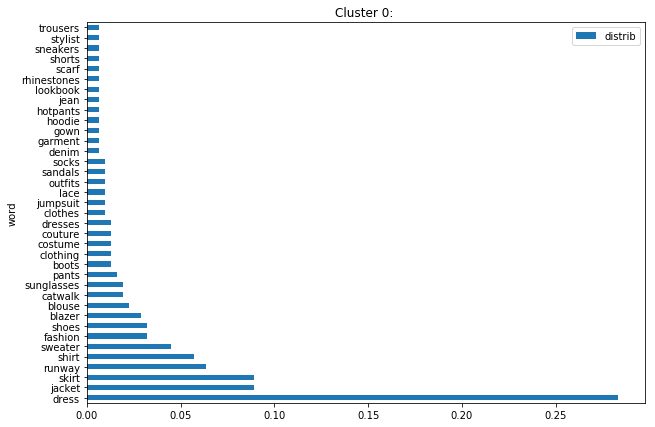

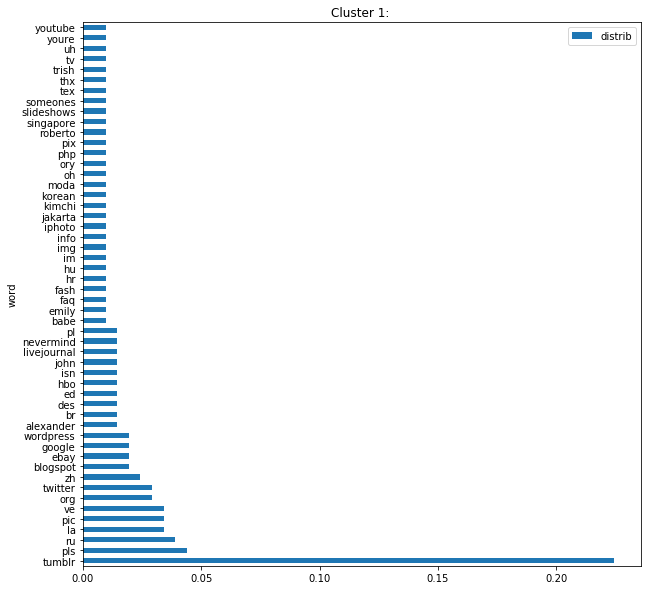

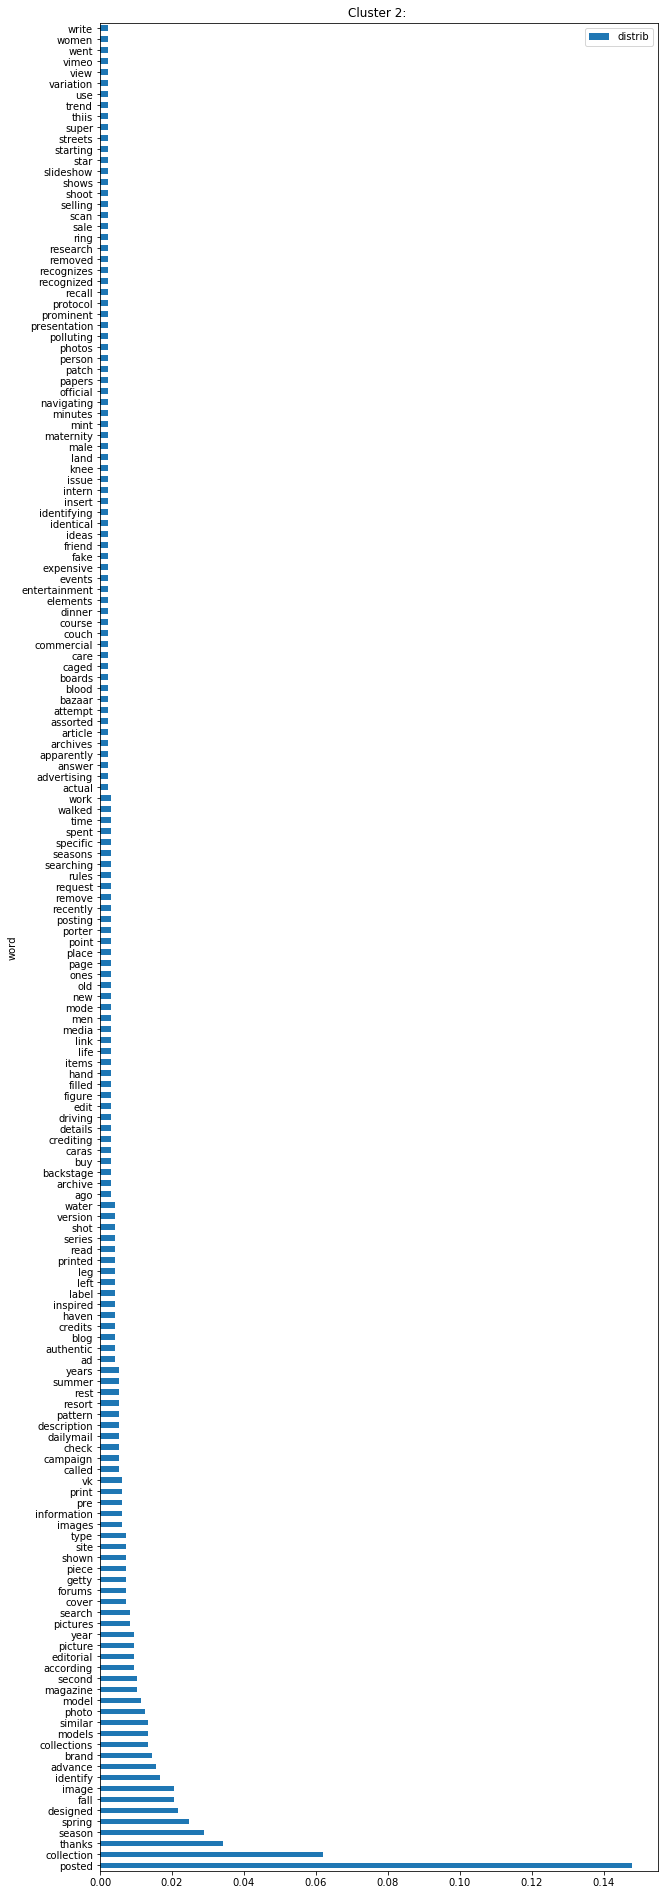

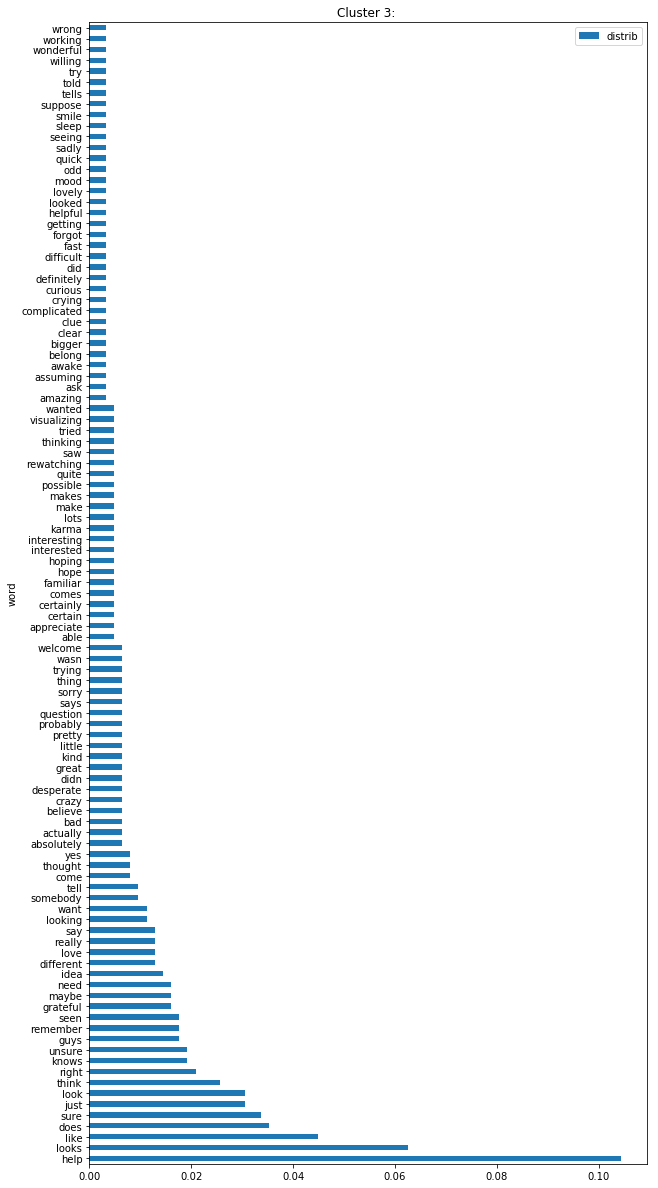

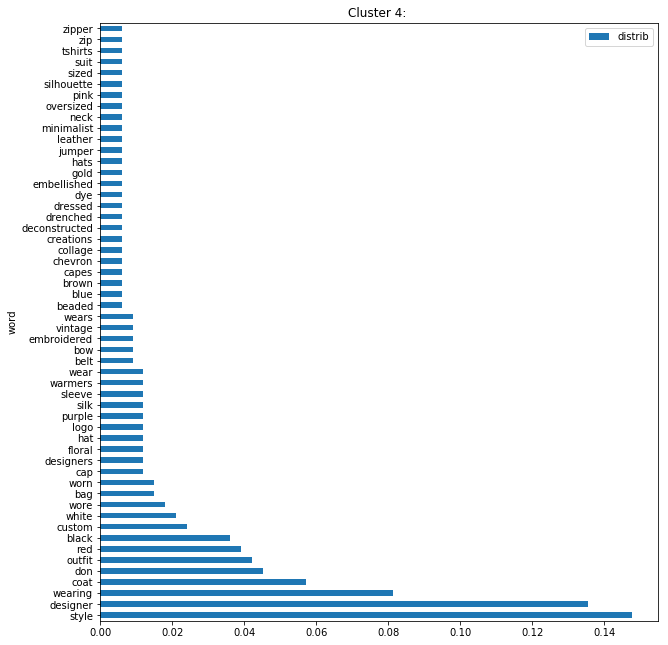

In [83]:
for name, group in word2vec_df.groupby(by='cluster'):
    group[['word','distrib']].set_index('word').plot(kind='barh', title='Cluster {}: '.format(name), figsize=(10,round(0.2*group.shape[0])))

### PCA to plot 

In [104]:
from sklearn.decomposition import PCA

pca= PCA(n_components=2)
vec2d= pca.fit_transform(vec_matrix)
word2vec_df['vector 2D']=pd.Series(list(vec2d))
word2vec_df.head()

,word,vector,cluster,count,distrib,vector 2D
116,dress,"[0.0043640137, -0.04345703, -0.087402344, 0.22...",0,89,0.283439,"[-0.28347695, -0.121395186]"
201,jacket,"[0.05444336, 0.018554688, -0.041015625, -0.160...",0,28,0.089172,"[-0.33024675, -0.6461109]"
372,skirt,"[-0.12060547, -0.17871094, -0.004760742, 0.048...",0,28,0.089172,"[-0.32866997, 1.368989]"
340,runway,"[-0.32421875, -0.043945312, 0.12011719, -0.086...",0,20,0.063694,"[-0.10582822, -0.19322303]"
359,shirt,"[0.03149414, 0.016723633, 0.14941406, -0.00836...",0,18,0.057325,"[-0.5081281, -0.42277837]"


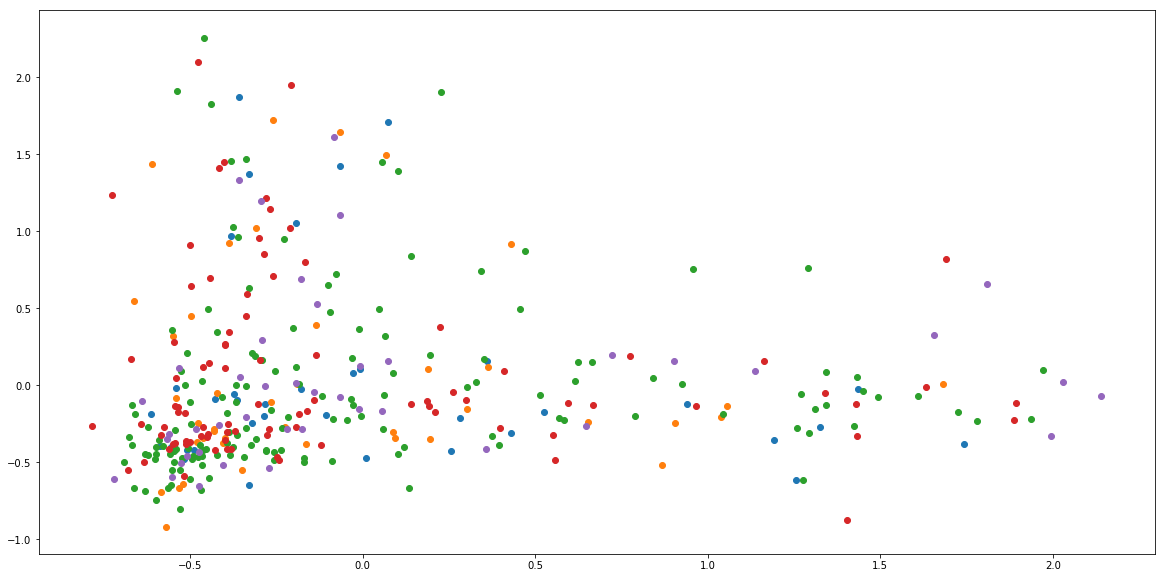

In [135]:

fig = plt.figure(figsize=(20,10))

for name, group in word2vec_df.groupby(by='cluster'):
    mat=group['vector 2D'].apply(pd.Series).as_matrix()
    plt.scatter(mat[:,0], mat[:, 1],label='cluster {}'.format(name) )
plt.show()

    

### Distribution of topics in docs

In [140]:
posts.head()


,ID,Thread ID,author,number,post,quote,tag,time
0,10105655,162311.0,Chanelcouture09,1.0,Moderator's Note: Falsely or non credited pi...,[],[],04-01-2012
1,10107983,162311.0,PonyShow,2.0,Credit: suninscorpio.tumblr.com,[],[],04-01-2012
2,10108063,162311.0,Chanelcouture09,3.0,^John Galliano Fall Winter 2009.,[],[],04-01-2012
3,10114851,162311.0,Menace,4.0,If the insect blouse and rainbow dress are ...,[],[],06-01-2012
4,10114885,162311.0,get fashion,5.0,The dress it's Christopher Kane Reso...,[],[],06-01-2012


In [151]:
tf_complete.shape
posts.shape

(614, 8)

In [162]:
def compute_doc_topic_distrib( posts,topic,tf_complete, tf_vectorizer_complete):
    docs_topics_distrib=[]
    for i in range(tf_complete.shape[0]):
        doc_topic_distrib=[]
        words_doc_count= tf_complete[i, :].sum()
        #compute percentage of words that belong to each cluster
        for name, group in topic.groupby(by='cluster'):
            #words in the cluster
            words_cluster=group['word']
            #corresponding index in tf matrix
            id_words_cluster= [tf_vectorizer_complete.vocabulary_[x] for x in words_cluster]
            #percentage of cluster words in that document
            doc_topic_distrib= doc_topic_distrib + [tf_complete[i, id_words_cluster].sum()/words_doc_count]
        docs_topics_distrib= docs_topics_distrib + [doc_topic_distrib]
    print(len(docs_topics_distrib))
    posts['topic distribution']= docs_topics_distrib
            
    
compute_doc_topic_distrib( posts,word2vec_df,tf_complete, tf_vectorizer_complete)   
    
    
    

/Users/valentine/anaconda/envs/ada/lib/python3.5/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in longlong_scalars
  del sys.path[0]


614


/Users/valentine/anaconda/envs/ada/lib/python3.5/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [163]:
posts.head()

,ID,Thread ID,author,number,post,quote,tag,time,topic distribution
0,10105655,162311.0,Chanelcouture09,1.0,Moderator's Note: Falsely or non credited pi...,[],[],04-01-2012,"[0.0, 0.0, 0.7647058823529411, 0.1764705882352..."
1,10107983,162311.0,PonyShow,2.0,Credit: suninscorpio.tumblr.com,[],[],04-01-2012,"[0.0, 1.0, 0.0, 0.0, 0.0]"
2,10108063,162311.0,Chanelcouture09,3.0,^John Galliano Fall Winter 2009.,[],[],04-01-2012,"[0.0, 1.0, 0.0, 0.0, 0.0]"
3,10114851,162311.0,Menace,4.0,If the insect blouse and rainbow dress are ...,[],[],06-01-2012,"[0.3333333333333333, 0.0, 0.16666666666666666,..."
4,10114885,162311.0,get fashion,5.0,The dress it's Christopher Kane Reso...,[],[],06-01-2012,"[0.5, 0.0, 0.0, 0.0, 0.5]"


In [164]:
topics_words.head()

,Topic ID,Words
0,0,"[style, shoe, guy, fashionshow, right, imag, c..."
0,1,"[doe, imag, campaign, site, zh, come, ad, welc..."
0,2,"[dress, design, help, wear, tumblr, collect, s..."
0,3,"[look, collect, help, runway, season, pictur, ..."
0,4,"[shirt, look, photo, want, collect, sure, mode..."


In [165]:
word2vec_df.head()

,word,vector,cluster,count,distrib,vector 2D
116,dress,"[0.0043640137, -0.04345703, -0.087402344, 0.22...",0,89,0.283439,"[-0.28347695, -0.121395186]"
201,jacket,"[0.05444336, 0.018554688, -0.041015625, -0.160...",0,28,0.089172,"[-0.33024675, -0.6461109]"
372,skirt,"[-0.12060547, -0.17871094, -0.004760742, 0.048...",0,28,0.089172,"[-0.32866997, 1.368989]"
340,runway,"[-0.32421875, -0.043945312, 0.12011719, -0.086...",0,20,0.063694,"[-0.10582822, -0.19322303]"
359,shirt,"[0.03149414, 0.016723633, 0.14941406, -0.00836...",0,18,0.057325,"[-0.5081281, -0.42277837]"


In [231]:
clusters=range(K)
words_clusters=[]
words_count=[]

for name, group in word2vec_df.groupby(by='cluster'):
    words=list(group['word'])[1:10]
    words_clusters=words_clusters + [words]
    words_count= words_count + [list(group['count'])[1:10]]


clusters_words=pd.DataFrame([pd.Series(clusters),pd.Series(words_clusters),pd.Series(words_count)]).transpose()
clusters_words=clusters_words.rename(columns={0:'Topic ID',1: 'Words', 2: 'Words count in dataset' })

clusters_words.head()

,Topic ID,Words,Words count in dataset
0,0,"[jacket, skirt, runway, shirt, sweater, fashio...","[28, 28, 20, 18, 14, 10, 10, 9, 7]"
1,1,"[pls, ru, la, pic, ve, org, twitter, zh, blogs...","[9, 8, 7, 7, 7, 6, 6, 5, 4]"
2,2,"[collection, thanks, season, spring, designed,...","[60, 33, 28, 24, 21, 20, 20, 16, 15]"
3,3,"[looks, like, does, sure, just, look, think, r...","[39, 28, 22, 21, 19, 19, 16, 13, 12]"
4,4,"[designer, wearing, coat, don, outfit, red, bl...","[45, 27, 19, 15, 14, 13, 12, 8, 7]"


/Users/valentine/anaconda/envs/ada/lib/python3.5/site-packages/ipykernel_launcher.py:211: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


  Topic ID                                              Words
0        0  [style, shoe, guy, fashionshow, right, imag, c...
0        1  [doe, imag, campaign, site, zh, come, ad, welc...
0        2  [dress, design, help, wear, tumblr, collect, s...
0        3  [look, collect, help, runway, season, pictur, ...
0        4  [shirt, look, photo, want, collect, sure, mode...


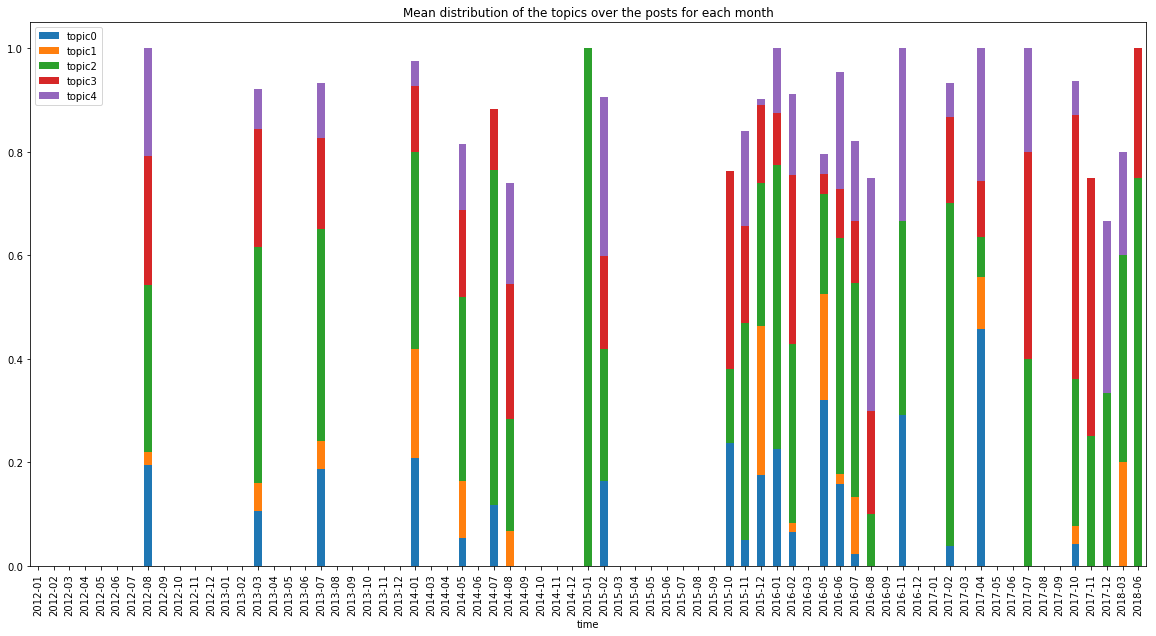

In [235]:
topics_time =topics_time_distrib(posts,'topic distribution', clusters_words)
print(topics_words)
topics_time.plot(x='time', figsize=(20,10), kind='bar', stacked = True) 
plt.title('Mean distribution of the topics over the posts for each month')

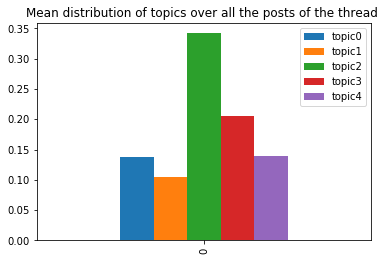

In [236]:
def topics_forum_distrib2(dataset, distrib_col, topic_dataset):
    # distrubtion of topics over the docs
    topics_forum=pd.DataFrame(columns= ['topic%d'%i for i in range(topic_dataset.shape[0])])
    distrib = np.nanmean(np.asarray(list(dataset[distrib_col])),axis=0)
    df= pd.DataFrame([list(distrib)], columns= ['topic%d'%i for i in range(topic_dataset.shape[0])])
    topics_forum=topics_forum.append(df, ignore_index=True)
    
    topics_forum.plot(kind='bar')
    return topics_forum



topics_thread= topics_forum_distrib2(posts, 'topic distribution', clusters_words)
plt.title('Mean distribution of topics over all the posts of the thread ')

/Users/valentine/anaconda/envs/ada/lib/python3.5/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


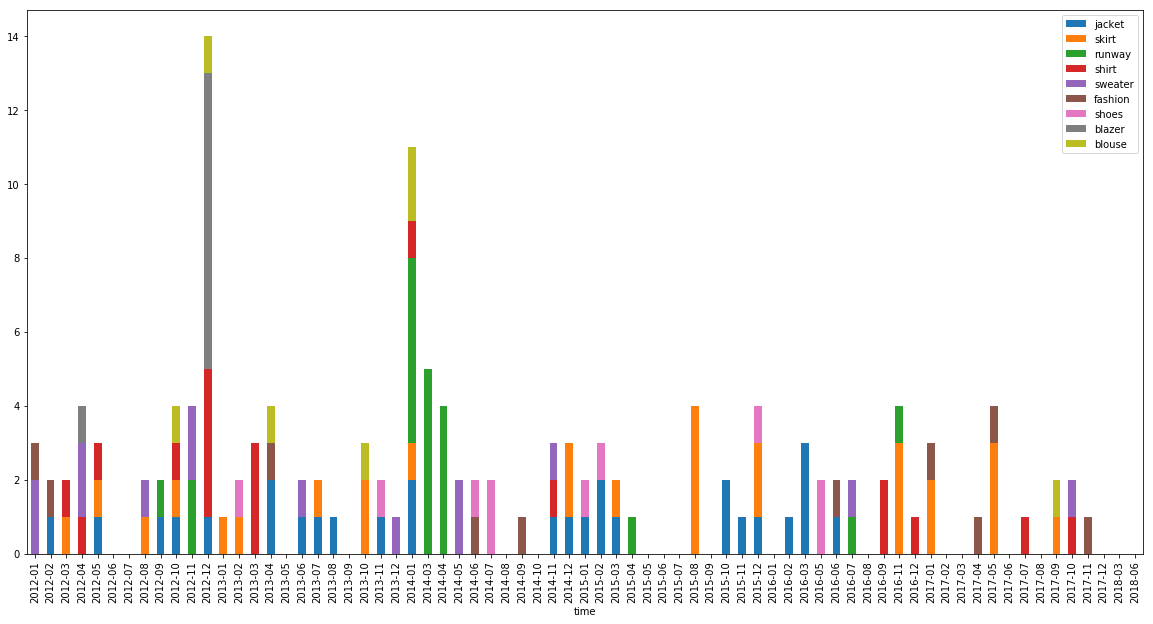

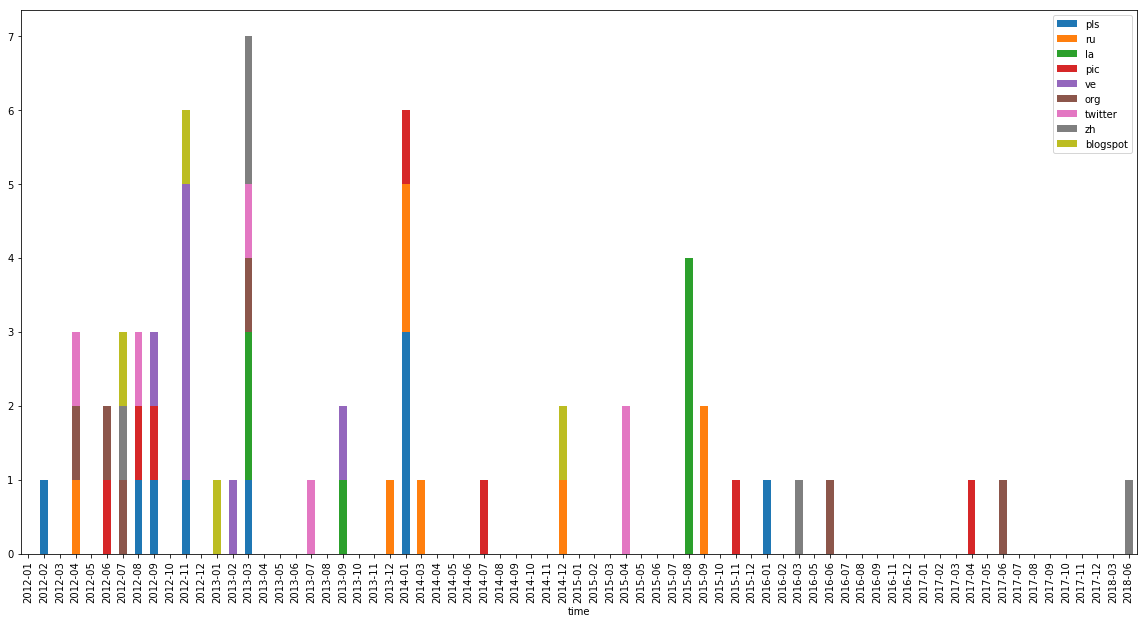

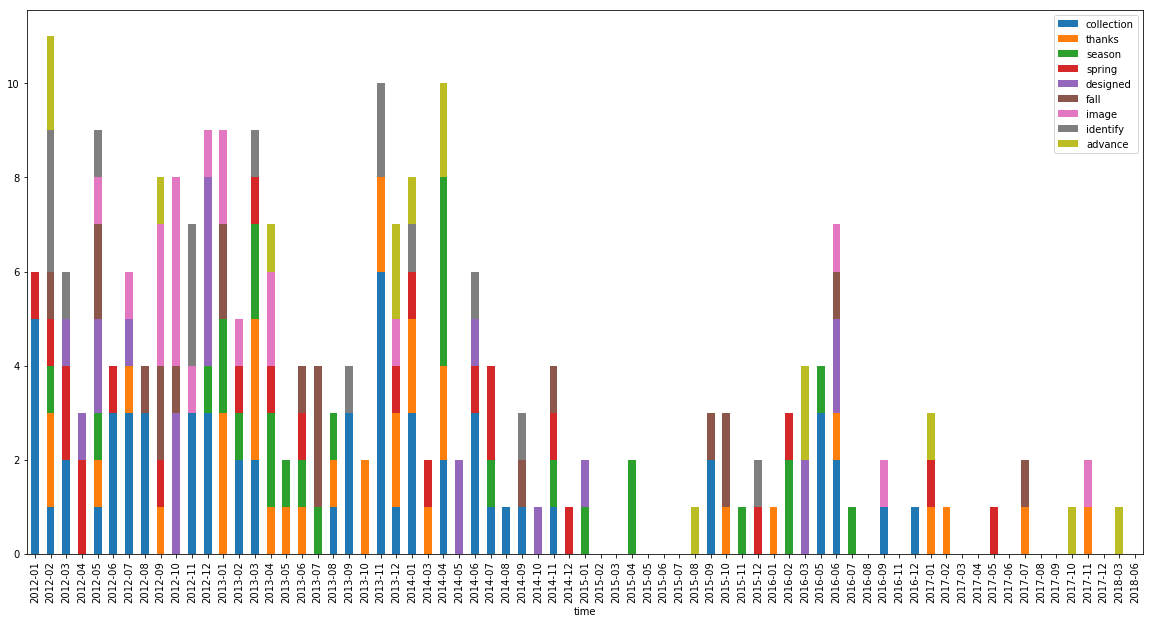

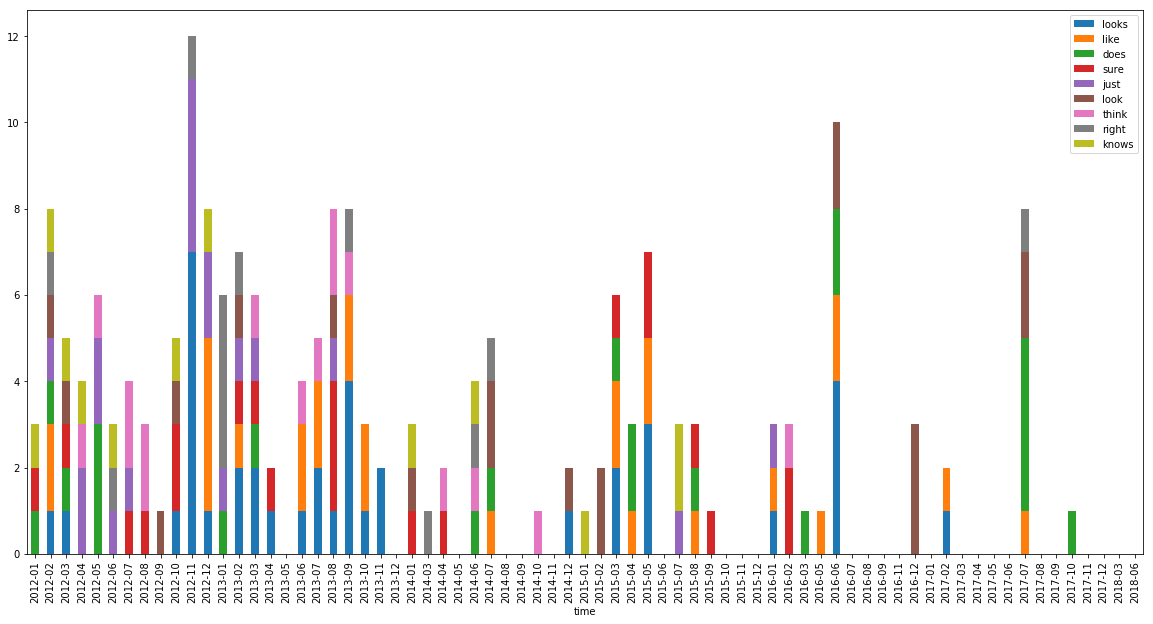

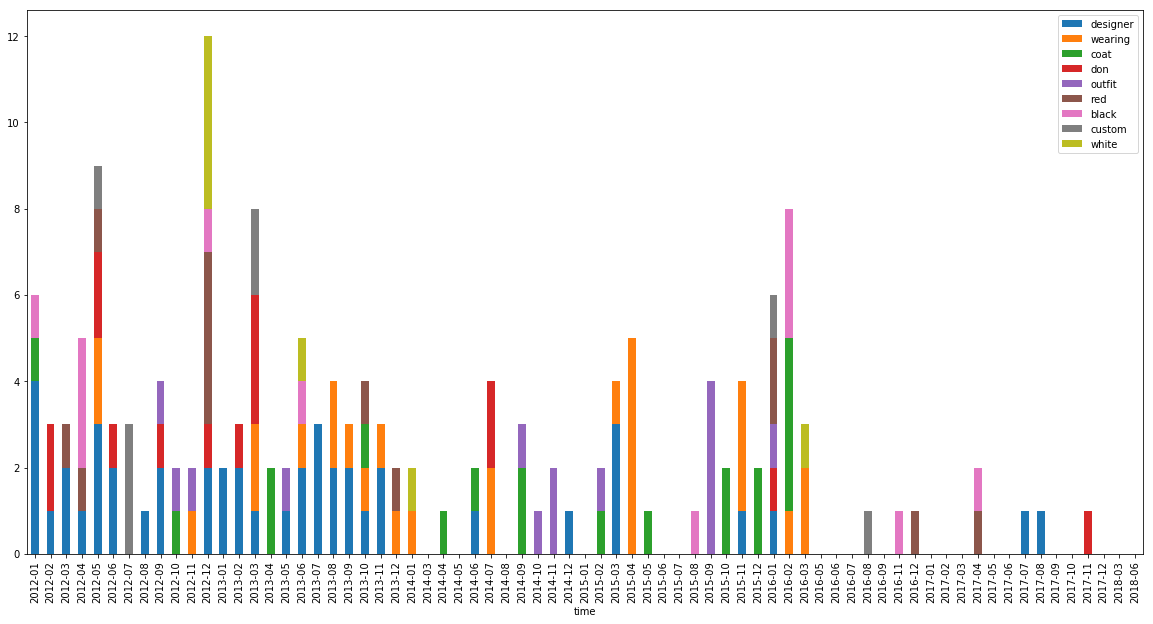

In [234]:
#words count per month per topic 
def words_count_time2(topics_dataset, tf, tf_feature_names,dataset):
    #for each topic 
    dataset['year_months']=pd.to_datetime(dataset['time'], errors='coerce').dt.to_period('M')
    words_count_time=pd.DataFrame()
    time=dataset['year_months'].unique()
    #print(time)
    for name, group in topics_dataset.groupby('Topic ID'):
        # for each word
        for word in list(group['Words'])[0]:
            #find ind of word 
            ind_word = tf_feature_names.index(word)
            word_counts=[]
            time2=[]
            for name , group in dataset.groupby('year_months'):
                #print(name)
                time2=time2 + [name]
                #get ind of docs in that period
                ind_doc = list(group.index)
                #get counts of this word in that period
                word_counts= word_counts  + list(np.ndarray.flatten(np.asarray(tf[ind_doc,ind_word].sum(axis=0))));
                
            words_count_time[word]= pd.Series(word_counts)
    time=pd.Series(time.tolist())
    time=time.dropna()
    words_count_time['time']=time
    words_count_time=words_count_time.sort_values('time')
    words_count_time= words_count_time[~words_count_time.time.isnull()]
    #words_count_time = words_count_time.set_index('time').drop(pd.NaT)


    #words_count_time= words_count_time.set_index(time)
    
    return words_count_time




words_count =words_count_time2(clusters_words, tf_complete, tf_feature_names_complete,posts)
for name, topic in clusters_words.groupby('Topic ID') :
    plt.figure(figsize=(20,5))
    col= ['time'] + list(topic['Words'])[0]
    topic_df=words_count[col]
    topic_df.plot(x='time', figsize=(20,10),kind='bar', stacked = True)


# Analysing LDA topics

### Distribution of topics in each post

Add the distributions of topics for each posts in the dataset.

In [54]:
posts = add_doc_topic_distrib(lda,tf,posts, 'topic distribution')
posts.head()


/Users/valentine/anaconda/envs/ada/lib/python3.5/site-packages/ipykernel_launcher.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,ID,Thread ID,author,number,post,quote,tag,time,topic distribution
0,10105655,162311.0,Chanelcouture09,1.0,Moderator's Note: Falsely or non credited pi...,[],[],04-01-2012,"[0.05113447194950324, 0.05024225202955166, 0.0..."
1,10107983,162311.0,PonyShow,2.0,Credit: suninscorpio.tumblr.com,[],[],04-01-2012,"[0.5998253317566564, 0.10002571550589369, 0.10..."
2,10108063,162311.0,Chanelcouture09,3.0,^John Galliano Fall Winter 2009.,[],[],04-01-2012,"[0.2, 0.2, 0.2, 0.2, 0.2]"
3,10114851,162311.0,Menace,4.0,If the insect blouse and rainbow dress are ...,[],[],06-01-2012,"[0.05040303393109789, 0.05127767269212639, 0.7..."
4,10114885,162311.0,get fashion,5.0,The dress it's Christopher Kane Reso...,[],[],06-01-2012,"[0.06668301155066558, 0.06668570573715711, 0.4..."


### Distribution of the topics over the posts for each month

Compute the mean of the topics' distribution over all the posts of a month. Enable us to see prominent topics over time.

/Users/valentine/anaconda/envs/ada/lib/python3.5/site-packages/ipykernel_launcher.py:211: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


  Topic ID                                              Words
0        0  [tumblr, advanc, shirt, outfit, pictur, help, ...
0        1  [brand, p, blazer, right, imag, zh, editori, p...
0        2  [dress, collect, help, coat, design, fall, sea...
0        3  [style, jacket, sweater, collect, fashionshow,...
0        4  [skirt, design, spring, season, collect, look,...


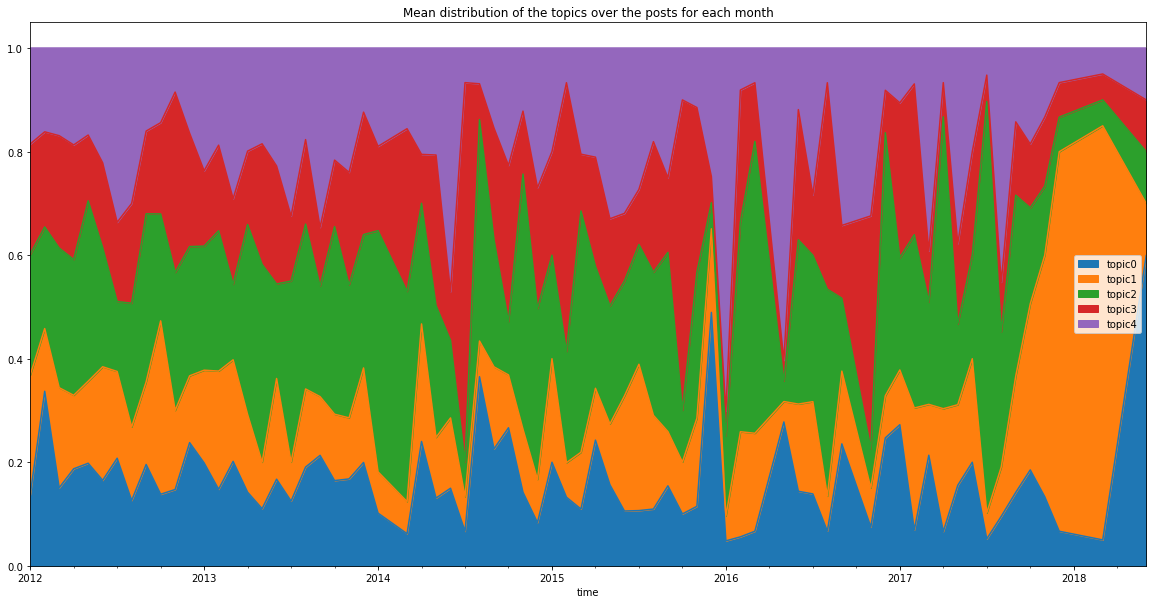

In [62]:
topics_time =topics_time_distrib(posts,'topic distribution', topics_words)
print(topics_words)
topics_time.plot(x='time', figsize=(20,10), kind='area', stacked = True) 
plt.title('Mean distribution of the topics over the posts for each month')

### Distribution of topics over all the posts of the thread 
Compute the mean of the topics distribution over all the posts. Enables us to see prominent topics in the dataset.

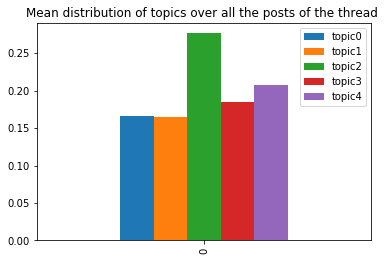

In [66]:
topics_forum= topics_forum_distrib(posts, 'topic distribution', topics_words)
plt.title('Mean distribution of topics over all the posts of the thread ')


### Words count in the dataset 
For each n_top word in each topic, compute its count over all the dataset.

In [67]:
topics_words= topics_words_distrib(topics_words, tf_feature_names, tf)
topics_words.head()
        

,Topic ID,Words,Words count in dataset
0,0,"[tumblr, advanc, shirt, outfit, pictur, help, ...","[43, 11, 16, 11, 11, 32, 2, 2, 2, 2]"
0,1,"[brand, p, blazer, right, imag, zh, editori, p...","[14, 6, 6, 6, 15, 5, 9, 6, 15, 5]"
0,2,"[dress, collect, help, coat, design, fall, sea...","[82, 59, 32, 19, 42, 15, 25, 10, 8, 15]"
0,3,"[style, jacket, sweater, collect, fashionshow,...","[47, 26, 13, 59, 6, 7, 6, 5, 4, 7]"
0,4,"[skirt, design, spring, season, collect, look,...","[27, 42, 23, 25, 59, 11, 11, 6, 5, 5]"


ValueError: incompatible sizes: argument 'height' must be length 5 or scalar

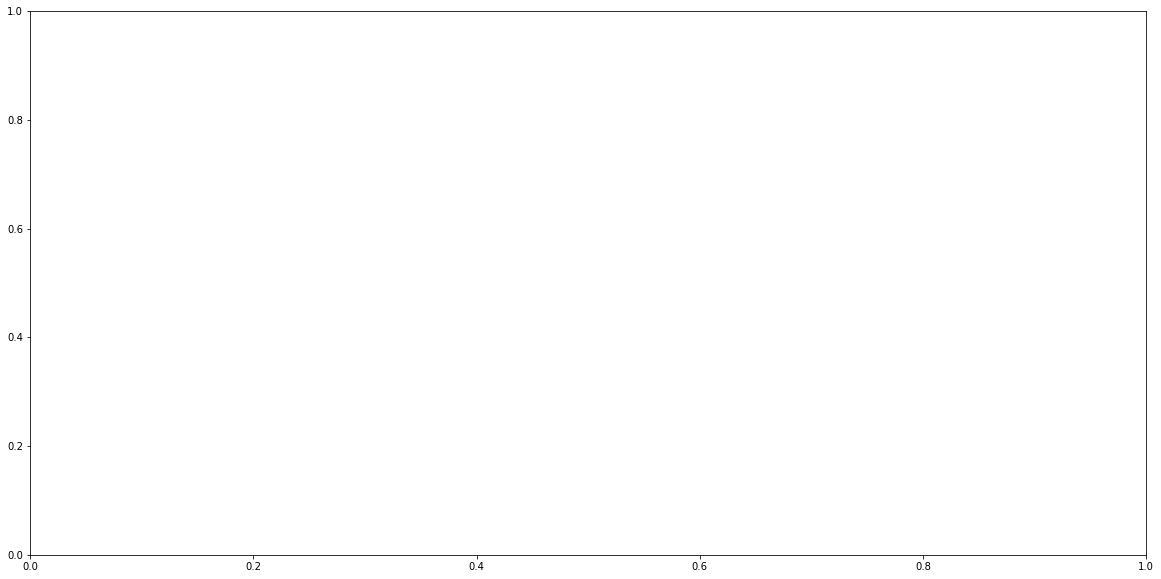

In [68]:
fig, ax= plt.subplots(figsize=(20,10))
tick_label=[]
tick_loc=[]
for i in range(topics_words.shape[0]):
    topic = topics_words.iloc[i]
    x= [0,1,2,3,4]
    x= [y+i*10 for y in x]
    tick_label=tick_label + topic['Words']
    tick_loc=tick_loc + x
    ax.bar(left=x, height=topic['Words count in dataset'], align='center', label='topic %d'%i)

plt.legend(loc='best')
ax.set_xticks(tick_loc)    
ax.set_xticklabels(tick_label,rotation='vertical')
ax.set_yscale('log')
plt.title('Words count in the dataset')
plt.show()


/Users/valentine/anaconda/envs/ada/lib/python3.5/site-packages/ipykernel_launcher.py:256: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


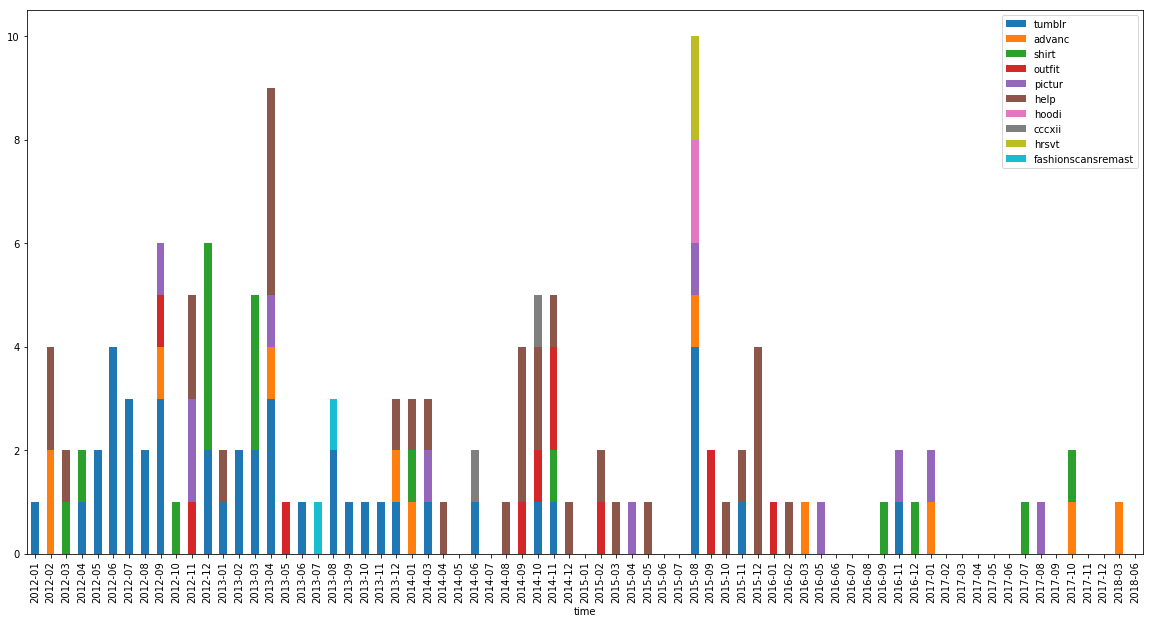

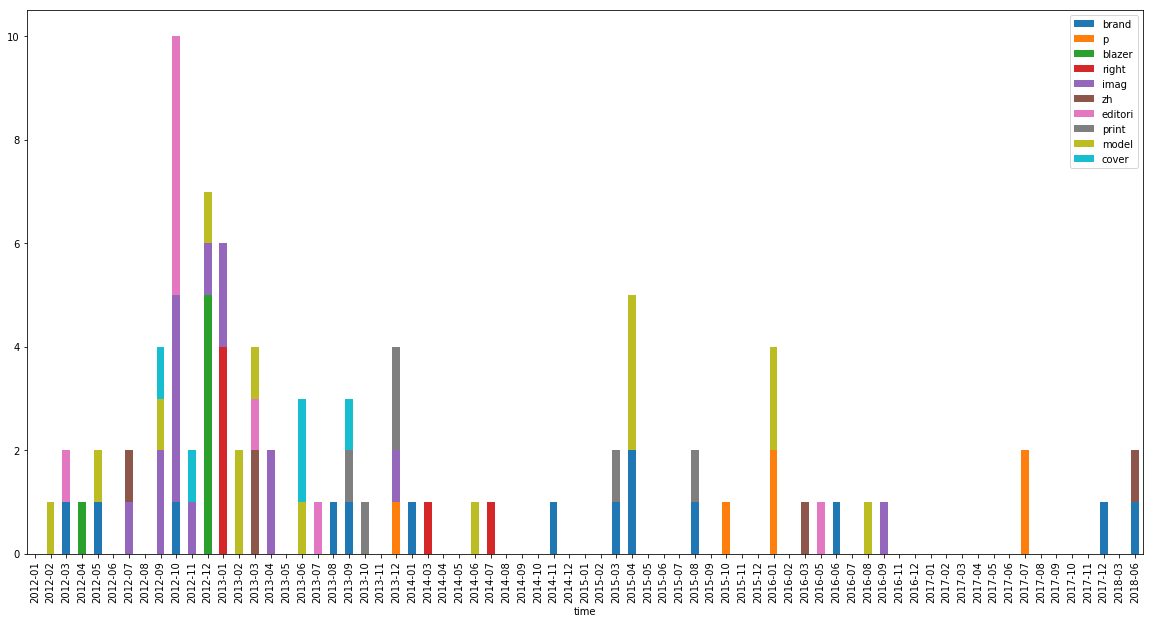

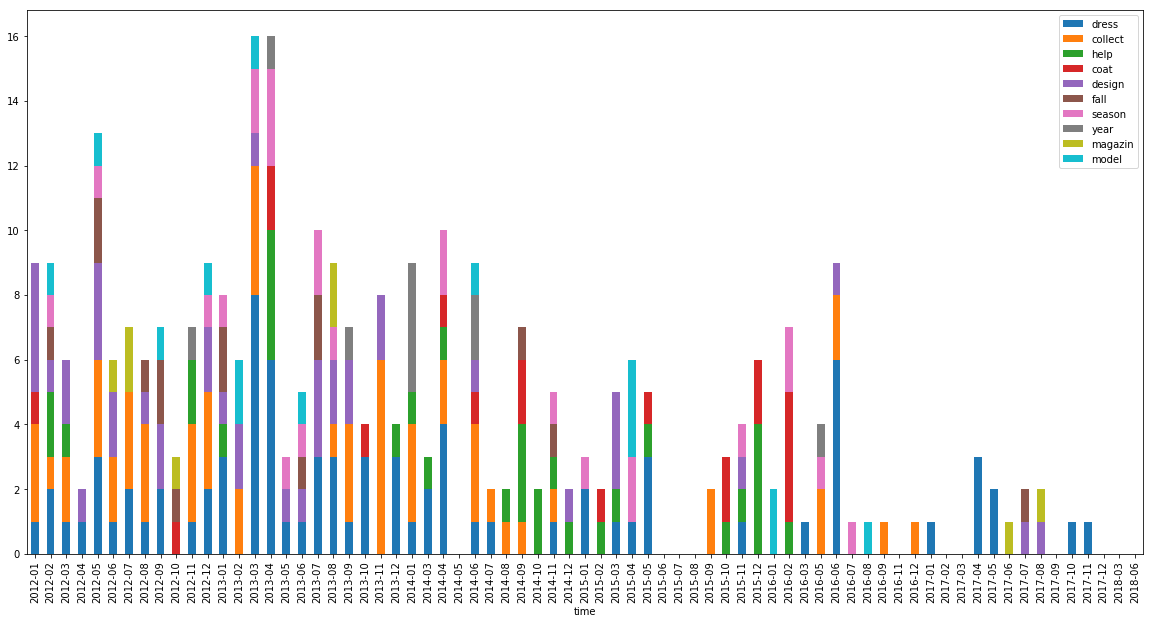

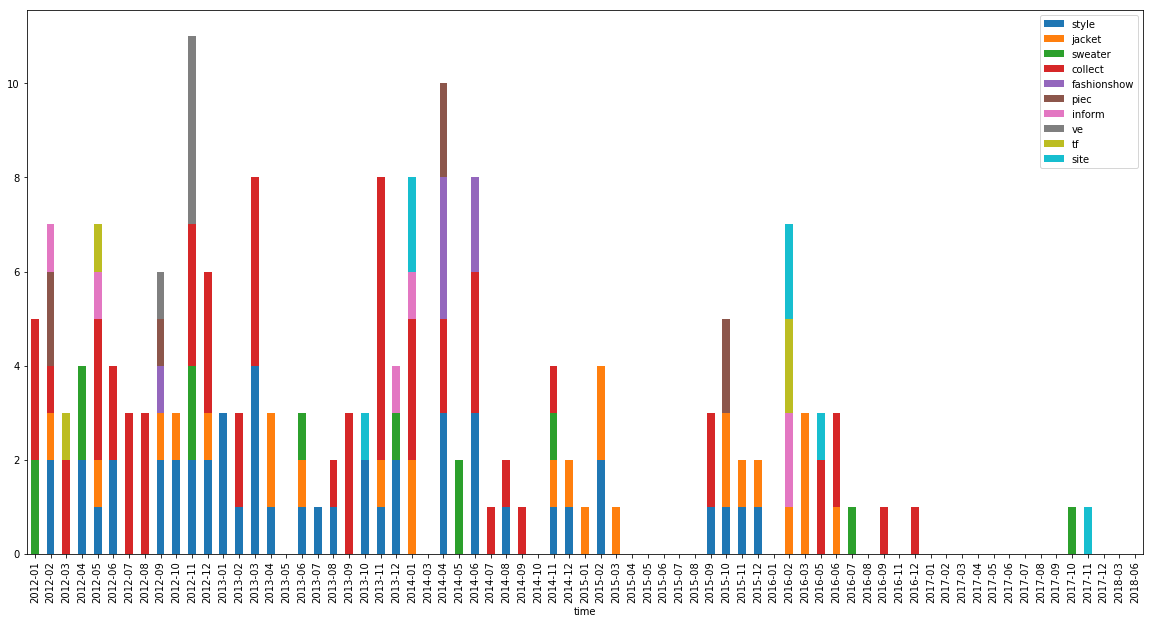

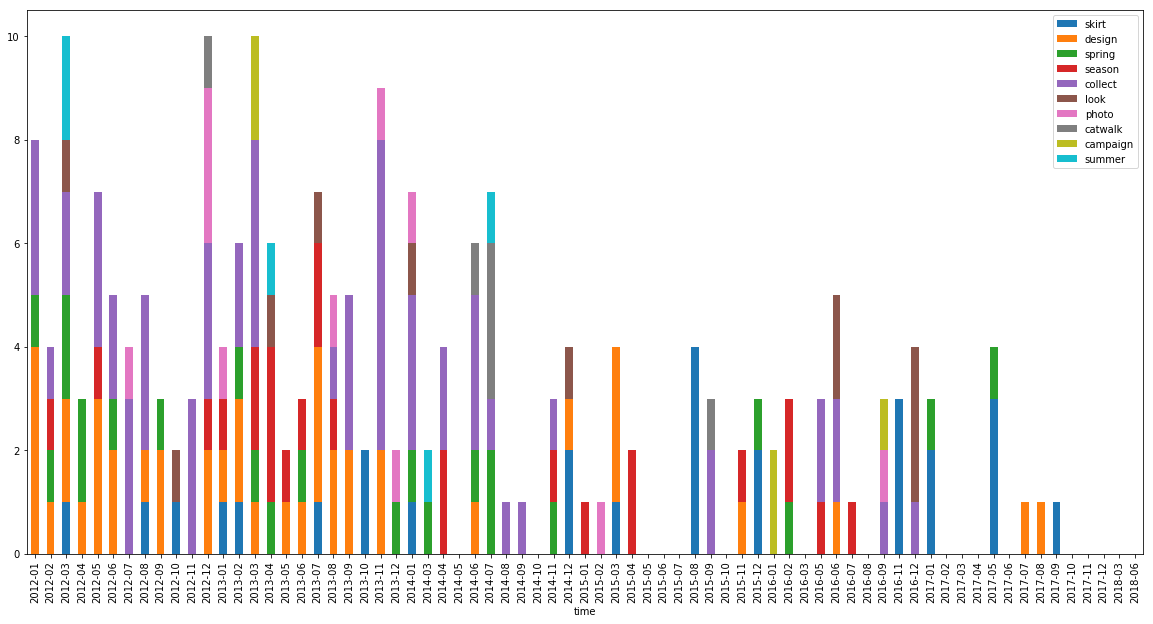

In [69]:
words_count =words_count_time(topics_words, tf, tf_feature_names,posts)
for name, topic in topics_words.groupby('Topic ID') :
    plt.figure(figsize=(20,5))
    col= ['time'] + topic['Words'][0]
    topic_df=words_count[col]
    topic_df.plot(x='time', figsize=(20,10),kind='bar', stacked = True)



## Proper Nouns

In [13]:
 # Try on proper Nouns


#keep proper names
print("Keeping only the text")
dataset=all_posts['post']
data_samples = [keep_propers(thread) for thread in dataset]

print("Extracting tf features for proper nouns..")
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2,
                                max_features=n_features,stop_words=set(my_stop_words)
                                ,token_pattern=u'(?ui)\\b\\w*[a-z]+\\w*\\b', ngram_range=(1, 3))
tf = tf_vectorizer.fit_transform(data_samples)

tf_feature_names = tf_vectorizer.get_feature_names()
tf_overall= tf.sum(axis=0)

proper_nouns_count=pd.DataFrame()
proper_nouns_count['proper nouns']=pd.Series(tf_feature_names)
proper_nouns_count['count']=pd.Series(np.squeeze(np.asarray(tf_overall)))
proper_nouns_count =proper_nouns_count.sort_values(by='count', ascending=False)
proper_nouns_count=proper_nouns_count.set_index('proper nouns')
proper_nouns_count.head()


Keeping only the text
Extracting tf features for proper nouns..


,count
proper nouns,
s,1469
quote,757
originally,633
quote originally,631
dior,625


In [15]:
proper_nouns_count_100 =proper_nouns_count.drop(['s', 'quote','originally','quote originally', 'fall','m','w','f','ve', 'd'], axis=0)

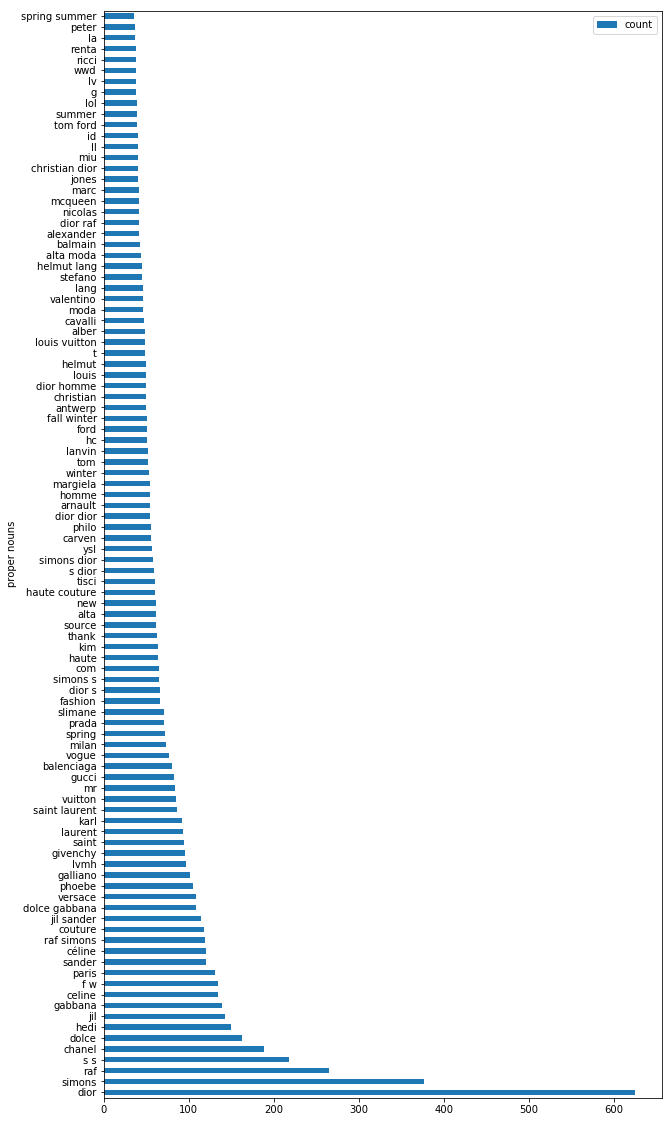

In [16]:

proper_nouns_count_100.head(100).plot(kind='barh', figsize=(10,20))

In [17]:
 

words_count =proper_nouns_count_time(proper_nouns_count_100.head(10).reset_index(), tf, tf_feature_names,all_posts)
print(words_count.head())



    dior  simons  raf  s s  chanel  dolce  hedi  jil  gabbana  celine    time
86     1       0    0    0       0      7     0    0        5       0 2007-01
87     0       1    1    2       0      0     0    1        0       0 2007-02
85     0       0    0    0       0      0     0    0        0       0 2007-09
88     1       0    0    3       1      0     0    0        0       0 2007-10
90     6       1    1    8       2      8     0    2       10       0 2009-03


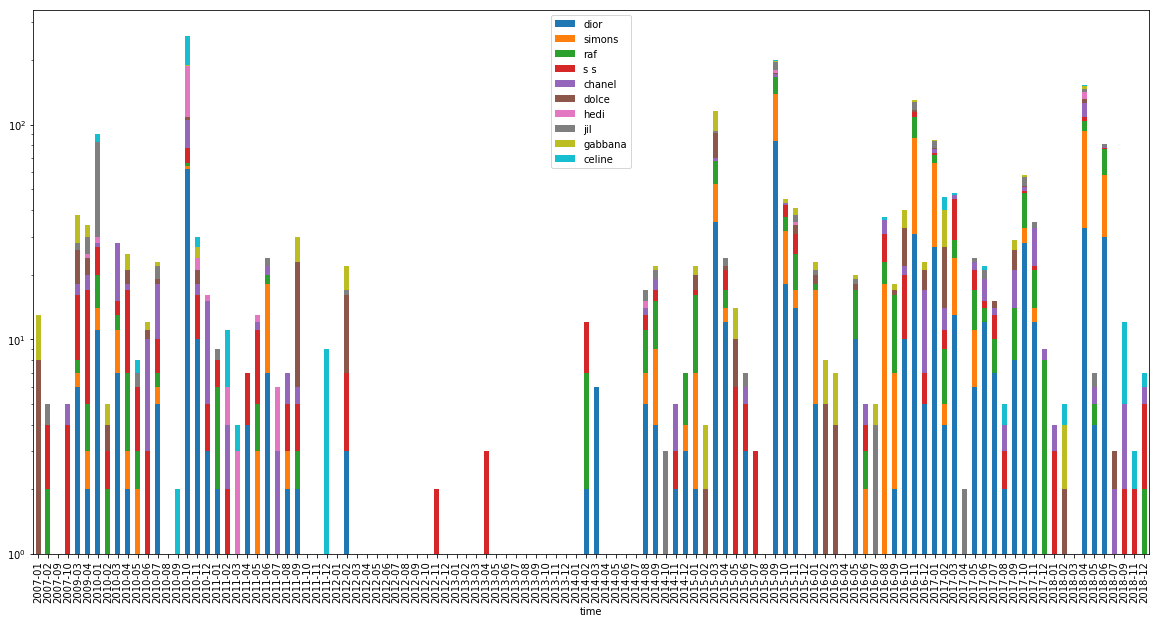

In [18]:

plt.figure(figsize=(20,5))
words_count.plot(x='time' , figsize=(20,10), kind='bar', stacked=True, logy=True)

# Colors mentionned

Loading colors dataset...


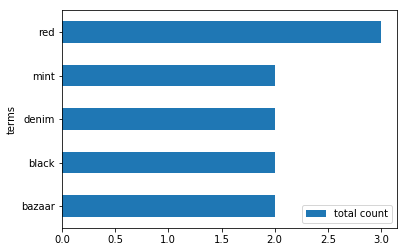

In [72]:


# extract colors or others terms from text , output list of the terms, the total count in dataset and each in doc
def terms_mentionned(tf_feature_names, terms):
    return [x for x in tf_feature_names if x in terms]
    

def terms_count(tf,tf_features, terms):
    terms_=terms_mentionned(tf_feature_names, terms)
    total_words_count=tf.sum(axis=0)
    terms_total_count = pd.Series(terms_).apply(lambda x: total_words_count[0,tf_feature_names.index(x)])
    terms_doc_count = pd.Series(terms_).apply(lambda x: tf.toarray()[:, tf_feature_names.index(x)])
    terms_names_count=pd.DataFrame({'terms': terms_,'total count': list(terms_total_count), 'doc count': terms_doc_count})
    return terms_names_count



print("Loading colors dataset...")
path='wikipedia_color_names.csv'
color= pd.read_csv(path)
color_names=color['Name'].apply(lambda x : x.lower())

colors_names_count= terms_count(tf, tf_feature_names, list(color_names))

colors_names_count.plot(x='terms', y='total count', kind='barh')

    

    

/Users/valentine/anaconda/envs/ada/lib/python3.5/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


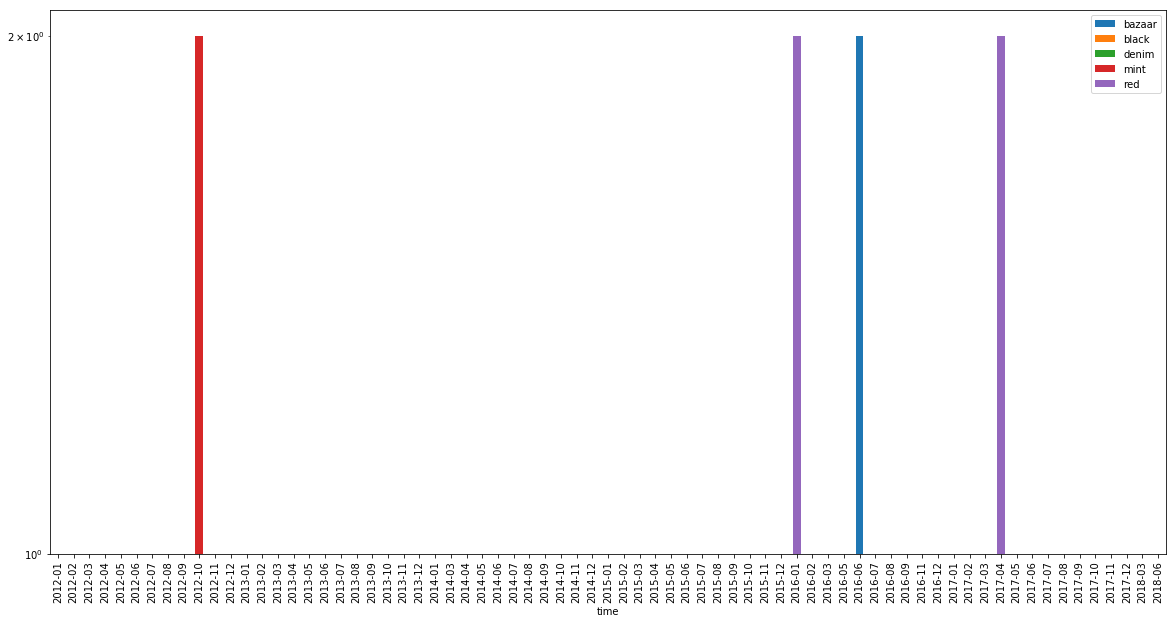

In [73]:
#words count per month per topic 
def terms_count_time(terms_count,dataset,tf, tf_feature_names):
    dataset['year_months']=pd.to_datetime(dataset['time'], errors='coerce').dt.to_period('M')
    terms_time=pd.DataFrame()
    time=dataset['year_months'].unique()
    #print(time)
    for word in terms_count['terms']:
        #find ind of word 
        ind_word = tf_feature_names.index(word)
        word_counts=[]
        time2=[]
        for name , group in dataset.groupby('year_months'):
            #print(name)
            time2=time2 + [name]
            #get ind of docs in that period
            ind_doc = list(group.index)
            #get counts of this word in that period
            word_counts= word_counts  + list(np.ndarray.flatten(np.asarray(tf[ind_doc,ind_word].sum(axis=0))));
            
        terms_time[word]= pd.Series(word_counts)
    time=pd.Series(time.tolist())
    time=time.dropna()
    terms_time['time']=time
    terms_time=terms_time.sort_values('time')
    terms_time= terms_time[~terms_time.time.isnull()]
    #words_count_time = words_count_time.set_index('time').drop(pd.NaT)
    return terms_time

colors_time = terms_count_time(colors_names_count,posts,tf, tf_feature_names)

plt.figure(figsize=(20,5))
colors_time.plot(x='time' , figsize=(20,10), kind='bar', stacked=True, logy=True)
    


In [74]:
time = pd.to_datetime(all_posts['time'], errors='coerce').dt.to_period('M')

In [75]:
colors_time = terms_count_time(colors_names_count,all_posts,tf, tf_feature_names)
colors_time.head()

IndexError: index (1673643) out of range

In [ ]:
season_terms=['fall', 'spring', 'summer','winter', 'ss','fw', 'spring summer', 'fall winter', 'autumn', 'autumn winter','aw']
season_term_count= terms_count(tf, tf_feature_names, season_terms)
season_term_count.plot(x='terms', y='total count', kind='barh')


season_time = terms_count_time(season_term_count,posts,tf, tf_feature_names)

plt.figure(figsize=(20,5))
season_time.plot(x='time' , figsize=(20,10), kind='line', stacked=True, logy=True)

### Others fashion attributes

In [154]:
patterns='animal print zebra leopard argyle checkered dotted floral herringbone houndstooth paisley pinstripes plaid print striped tartan'.split()
materials='cotton denim fur lace leather silk tweed wool'.split()
structure= 'frilly knitted ruffled wrinkled'.split()
styles='20’s 50’s 60’s 70’s 80’s 90’s bohemian business casual dandy hip hop hippie mod nerd outdoor preppy punk rock romantic sports wedding spring summer autumn winter'.split()
clothes=['long dress','coat','jacket','cloak','robe', 'suit', 'undergarment', 'uniform', 'sweater', 'short dress','shirt', 't-shirt', 'blouses' ,'vest', 'polo shirt']

/Users/valentine/anaconda/envs/ada/lib/python3.5/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/Users/valentine/anaconda/envs/ada/lib/python3.5/site-packages/matplotlib/axes/_base.py:3193: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=1.0, top=1.0
  'bottom=%s, top=%s') % (bottom, top))


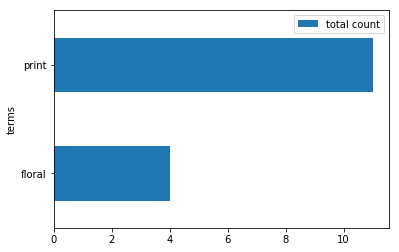

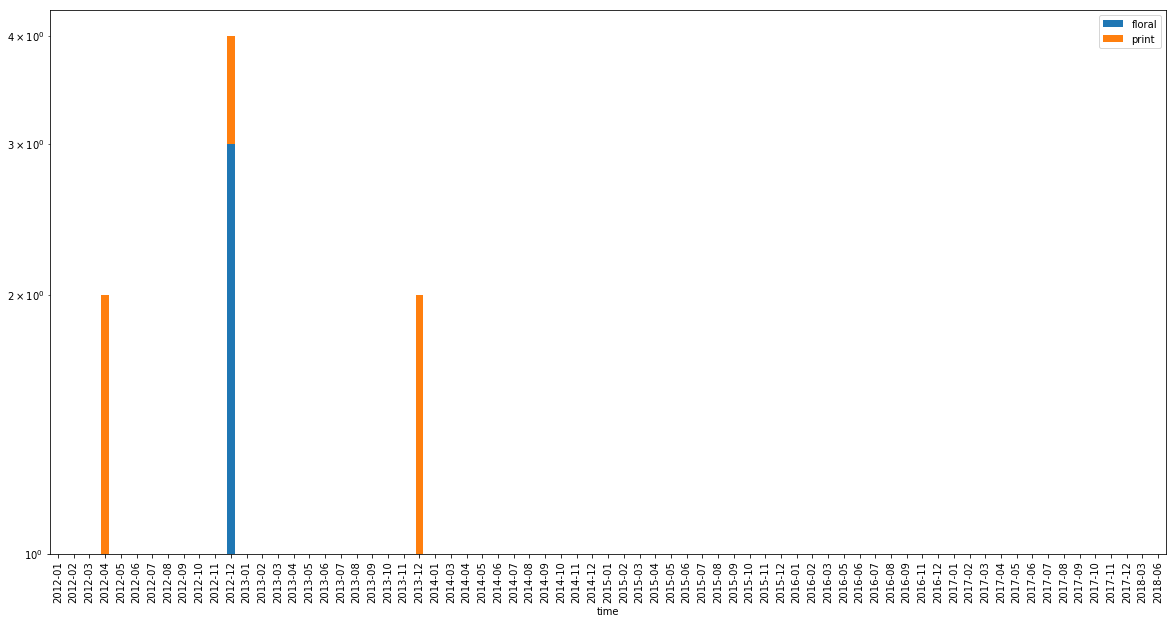

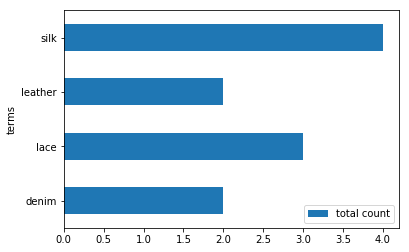

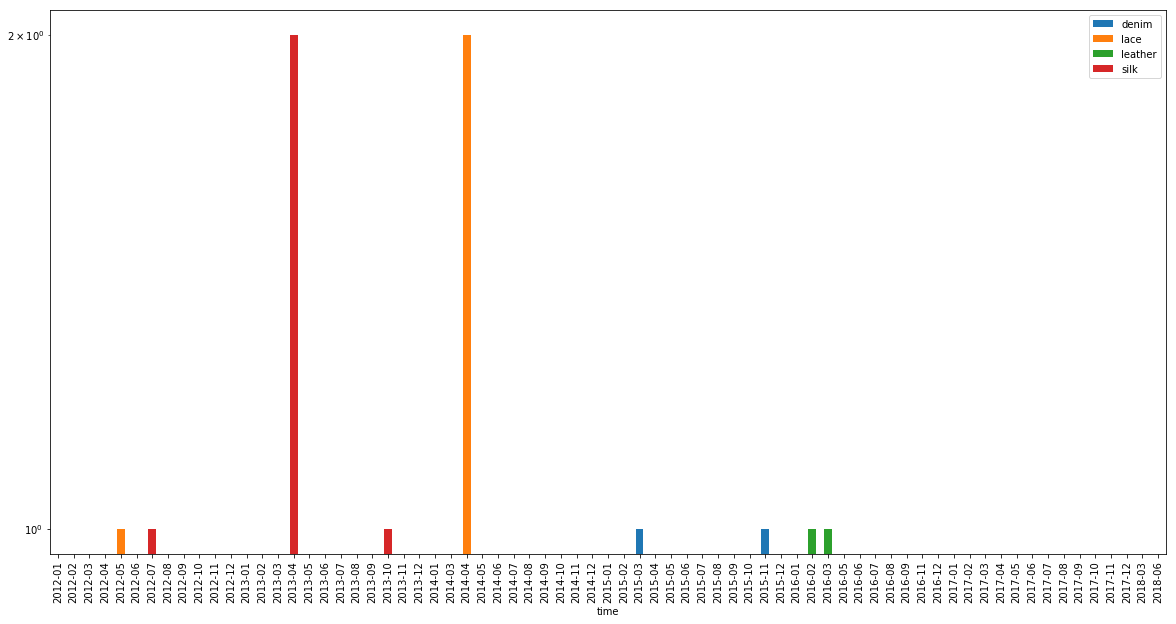

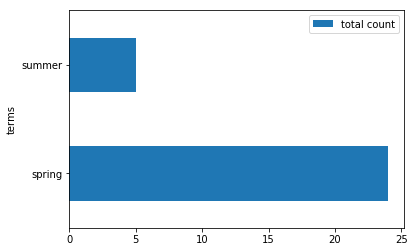

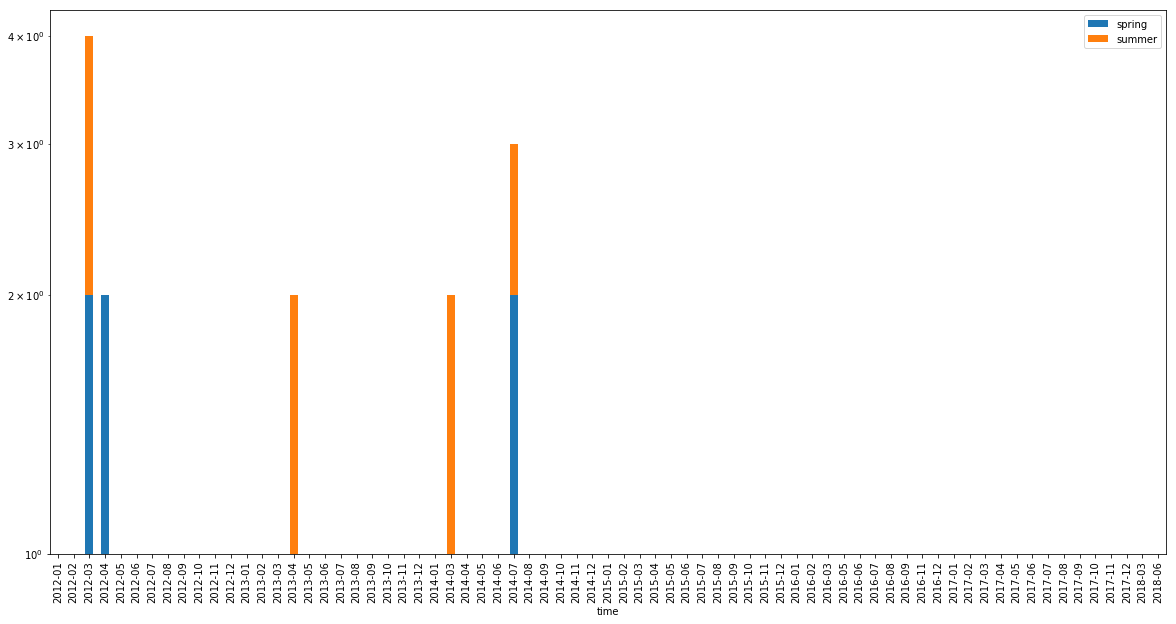

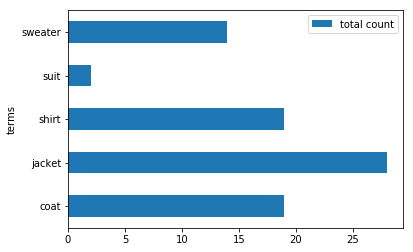

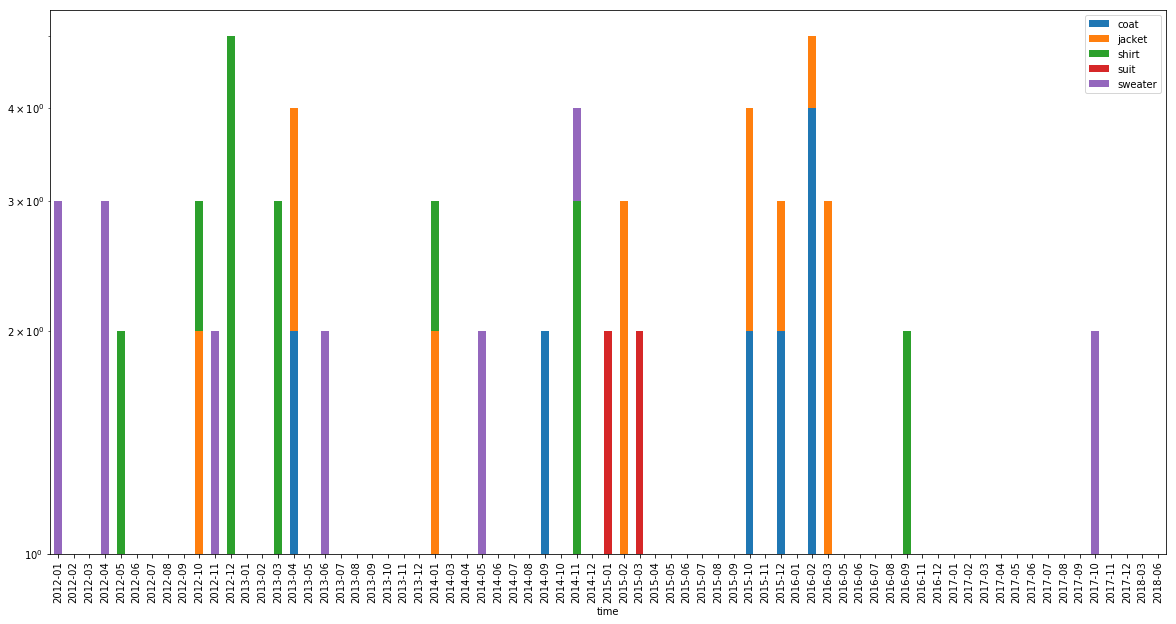

In [155]:

for terms in [patterns,materials,styles, clothes]:
    term_count= terms_count(tf, tf_feature_names, terms)
    term_count.plot(x='terms', y='total count', kind='barh')


    terms_time = terms_count_time(term_count,posts,tf, tf_feature_names)

    plt.figure(figsize=(20,5))
    terms_time.plot(x='time' , figsize=(20,10), kind='bar', stacked=True, logy=True)

### Sentiment analysis

In order to perform sentiment analysis, I though to use a pretrained model on twitter dataset, as posts have similar lenght as tweets 

In [52]:
mean_characters_per_post=posts['post'].apply(len).mean()
mean_characters_per_post

122.37133550488599

In [8]:
dataset.values

array([' Moderator\'s Note:  Falsely or non credited pictures will be deleted.For more specific information on the crediting of pictures see Here. Tumblr, Blogger or Flickr are not adequate credits to an image, please specify the name of the blog (i.e. V-Magazine.tumblr.com). Please remember that this thread is intended for identifying images from Runway Shows and Editorials. If your question is about what a Celebrity is wearing or ID on items seen on Streetstyle Images, please use the "Who Designed This?" thread in Star Style.  Thank You. ',
       '   Credit: suninscorpio.tumblr.com    ',
       '          ^John Galliano Fall Winter 2009.    ',
       "   If the insect blouse and rainbow dress are different designers... I'd like to know both. Thank you   image credit: designscene.net ",
       "          The dress it's Christopher Kane Resort 2012  style.com    ",
       ' Menace, the shirt is Frankie Morello Resort 2012.   vogue.it ',
       " http://tinypic.com/view.php?pic=iwujvb&

In [7]:
import tweetment.tweetment as TweetMent

import datetime

classifier = TweetMent.SentimentClassifier('model.pkl')
print("%s: Model is loaded." % (datetime.datetime.now().time()))


sentiment=[]
for line in dataset.values:
    tweet = line.strip()
    sentiment = sentiment + [classifier.classify(tweet)]
    





/Users/valentine/anaconda/envs/ada/lib/python3.5/site-packages/sklearn/base.py:311: UserWarning: Trying to unpickle estimator LinearSVC from version pre-0.18 when using version 0.19.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


09:30:55.701824: Model is loaded.


True